In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Embedding, Flatten, Dropout,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('final_combined_dataset.csv')

# geocode_list = [3303807]
# df = df[df['geocode'].isin(geocode_list)]
# df = df.drop(columns=['geocode'])

df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])
# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)


df["year_sin"] = np.sin(2 * np.pi * df["year"] / df["year"].max())
df["year_cos"] = np.cos(2 * np.pi * df["year"] / df["year"].max())


# Step 2: Create lag features
def create_lags(dataframe, group_col, target_col, lags, inplace = False):
    if isinstance(target_col, list):  # If target_col is a list of columns
        for col in target_col:
            for lag in lags:
                if inplace:
                    dataframe[target_col] = dataframe.groupby(group_col)[col].shift(lag)
                else:
                    dataframe[f'{col}_lag{lag}'] = dataframe.groupby(group_col)[col].shift(lag)
    else:  # If target_col is a single column
        for lag in lags:
            if inplace:
                dataframe[target_col] = dataframe.groupby(group_col)[target_col].shift(lag)
            else:
                dataframe[f'{target_col}_lag{lag}'] = dataframe.groupby(group_col)[target_col].shift(lag)
    return dataframe

# Lag cases by 1 and 2 weeks
data = create_lags(df, group_col='city', target_col='cases', lags=[0,1, -2])

# Lag weather-related variables by 5 and 6 weeks for each city
weather_columns = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging']
data = create_lags(df, group_col='city', target_col=weather_columns, lags=[3,4])
data = data.dropna().reset_index(drop=True)


# Initialize the Label Encoder
label_encoder = LabelEncoder()

# Fit and transform the 'geocode' column
data['geocode'] = label_encoder.fit_transform(data['geocode'])

train_data = data[data['date'].dt.year <= 2020]
test_data = data[data['date'].dt.year >= 2021]

print("Training set shape:", train_data.shape)
print("Test set shape:", test_data.shape)

X_train = train_data.drop(columns=['cases','cases_lag-2'])
y_train = train_data[['cases_lag-2']]

X_test = test_data.drop(columns=['cases','cases_lag-2'])
y_test = test_data[['cases_lag-2']]

data = data.drop(columns=['date','cases_per_100k'])


columns_not_to_scale = ['week_sin', 'week_cos', 'month_sin', 'month_cos', 'week', 'lat', 'long', 
                    'geocode', 'year_sin', 'year_cos'] 

selected_columns = [
    'cases_lag0', 'cases_lag1',
    'temp_avg', 'humidity_avg',
    # 'precipitation_avg_ordinary_kriging_lag3',
    'precipitation_avg_ordinary_kriging_lag4',
    # 'week_sin', 'month_sin', 'week_cos', 'month_cos',
    # 'week',
    # 'cases_per_100k',
    # 'vim',
    'geocode'
]


X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

numeric_cols = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'int64', 'float32', 'int32'] 
                   and col not in columns_not_to_scale]


# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale the selected numeric features
X_train[numeric_cols] = feature_scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = feature_scaler.transform(X_test[numeric_cols])

# Scale the target variable
y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)


# Filter the dataset to keep only these columns
X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

Training set shape: (42406, 54)
Test set shape: (9282, 54)


In [3]:
seq_length = 4

def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length].values)  # Select seq_length rows as input
        y.append(target[i + seq_length])  # Select the next row as the target
    return np.array(X), np.array(y)


def create_sequences_geocode_wise(data, target, seq_length):
    X, y = [], []

    # Group by geocode
    for geocode in data['geocode'].unique():
        geocode_data = data[data['geocode'] == geocode]  # Filter rows for this geocode
        geocode_target = target[data['geocode'] == geocode]  # Corresponding target values

        # Create sequences for this geocode
        X_geo, y_geo = create_sequences(geocode_data, geocode_target, seq_length)

        # Append to the lists
        X.append(X_geo)
        y.append(y_geo)

    # Concatenate all geocode-wise sequences
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y


# Create sequences for training (geocode-wise)
X_train, y_train = create_sequences_geocode_wise(X_train, y_train, seq_length)

# Create sequences for testing (geocode-wise)
X_test, y_test = create_sequences_geocode_wise(X_test, y_test, seq_length)

# Print the shapes to verify
print("X_train shape:", X_train.shape)  # (samples, timesteps, features)
print("y_train shape:", y_train.shape)  # (samples,)
print("X_test shape:", X_test.shape)    # (samples, timesteps, features)
print("y_test shape:", y_test.shape)    # (samples,)

# Encode geocode as integers
df['geocode'] = df['geocode'].astype('category').cat.codes  
num_geocodes = df['geocode'].nunique()  # Get number of unique geocodes

# Separate geocode after sequence creation
X_train_lstm = X_train[:, :, :-1]  # Exclude last column (geocode)
X_train_geocode = X_train[:, 0, -1].astype(int)  # Extract geocode as separate categorical input

X_test_lstm = X_test[:, :, :-1]
X_test_geocode = X_test[:, 0, -1].astype(int)

# Print shapes for verification
print("X_train_lstm shape:", X_train_lstm.shape)  # (samples, timesteps, features)
print("X_train_geocode shape:", X_train_geocode.shape)  # (samples,)
print("y_train shape:", y_train.shape)

# Define LSTM model with geocode embeddings
seq_length = X_train_lstm.shape[1]  
num_features = X_train_lstm.shape[2]  


# LSTM Branch
# Minimal LSTM model with essential components only

# LSTM Branch (Time-Series Data)
lstm_input = Input(shape=(seq_length, num_features), name="lstm_input")

# First LSTM Layer with Dropout
lstm_layer = LSTM(64)(lstm_input)

# lstm_layer = LSTM(64, return_sequences=True)(lstm_input)  
# dropout_1 = Dropout(0.3)(lstm_layer)  # Drop 30% of neurons

# # Second LSTM Layer with Dropout
# lstm_layer_2 = LSTM(32)(dropout_1)
# dropout_2 = Dropout(0.3)(lstm_layer_2)  # Drop 30% of neurons

# Geocode Embedding Branch
geocode_input = Input(shape=(1,), name="geocode_input")
geocode_embedding = Embedding(input_dim=num_geocodes + 1, output_dim=7)(geocode_input)
geocode_embedding = Flatten()(geocode_embedding)

# Merge Both Branches
merged = Concatenate()([lstm_layer, geocode_embedding])

# Output Layer
output = Dense(1, activation='linear')(merged)

# Build Model
model = Model(inputs=[lstm_input, geocode_input], outputs=output)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mae',
    metrics=['mae']
)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)

history = model.fit(
    [X_train_lstm, X_train_geocode],
    y_train,
    validation_data=([X_test_lstm, X_test_geocode], y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate
test_loss, test_mae = model.evaluate([X_test_lstm, X_test_geocode], y_test)
print(f"Test MAE: {test_mae:.4f}")


X_train shape: (42042, 4, 6)
y_train shape: (42042, 1)
X_test shape: (8918, 4, 6)
y_test shape: (8918, 1)
X_train_lstm shape: (42042, 4, 5)
X_train_geocode shape: (42042,)
y_train shape: (42042, 1)
Epoch 1/100


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['lstm_input', 'geocode_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0037 - mae: 0.0037 - val_loss: 6.8751e-04 - val_mae: 6.8751e-04 - learning_rate: 0.0010
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0017 - mae: 0.0017 - val_loss: 7.0868e-04 - val_mae: 7.0868e-04 - learning_rate: 0.0010
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0015 - mae: 0.0015 - val_loss: 5.9037e-04 - val_mae: 5.9037e-04 - learning_rate: 0.0010
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0013 - mae: 0.0013 - val_loss: 8.1150e-04 - val_mae: 8.1150e-04 - learning_rate: 0.0010
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0012 - mae: 0.0012 - val_loss: 4.7275e-04 - val_mae: 4.7275e-04 - learning_rate: 0.0010
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0011 - mae: 0.0011 - val_loss: 3.6881e-04 - val_mae: 3.6881e-04 - learning_rate: 0.0010
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0010 - mae: 0.0010 - val_loss: 3.0910e-04 -

In [4]:
# Make predictions on the test data


predictions = model.predict([X_test_lstm, X_test_geocode])

# Rescale actual values back to the original scale
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Rescale the predicted values back to the original scale
test_predictions_rescaled = target_scaler.inverse_transform(predictions)
test_predictions_rescaled = np.clip(test_predictions_rescaled, 0, None)

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score

# Predictions for training set
train_predictions = model.predict([X_train_lstm, X_train_geocode])
y_train_rescaled = target_scaler.inverse_transform(y_train.reshape(-1, 1))
train_predictions_rescaled = target_scaler.inverse_transform(train_predictions)
train_predictions_rescaled = np.clip(train_predictions_rescaled, 0, None)

# R² for train set
r2_train = r2_score(y_train_rescaled, train_predictions_rescaled)

# R² for test set
r2_test = r2_score(y_test_rescaled, test_predictions_rescaled)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions_rescaled))

# Print metrics
print(f"Train R²: {r2_train:.4f}")
print(f"Test R²: {r2_test:.4f}")
print(f"Test MAE: {test_mae:.4f}")  # Already printed before, but reprinted here for completeness
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Train R²: 0.9082
Test R²: 0.7880
Test MAE: 0.0001
Train RMSE: 227.41912425418198
Test RMSE: 13.618741686662279


In [5]:
# Step 1: Prepare test_df
test_df = test_data.copy().reset_index(drop=True)
test_df[numeric_cols] = feature_scaler.transform(test_df[numeric_cols])


# Step 2: Drop the first `seq_length` rows *per geocode*
filtered_test_df_list = []

for geocode in test_df['geocode'].unique():
    geo_df = test_df[test_df['geocode'] == geocode]
    if len(geo_df) > seq_length:
        geo_df = geo_df.iloc[seq_length:]  # drop first few rows
        filtered_test_df_list.append(geo_df)



# Step 3: Concatenate and reset index
test_df_seq = pd.concat(filtered_test_df_list).reset_index(drop=True)

test_df_seq['lstm_pred'] = test_predictions_rescaled.flatten()
test_df_seq['actual'] = y_test_rescaled.flatten()
# Step 4: Decode geocode if label encoded
test_df_seq['geocode'] = label_encoder.inverse_transform(test_df_seq['geocode'].astype(int))

# Step 5: Add year column
test_df_seq['year'] = pd.to_datetime(test_df_seq['date']).dt.year

# Step 6: Export year-wise predictions
test_df_seq[test_df_seq['year'] == 2021][['geocode', 'lstm_pred', 'actual']].to_csv('lstm_preds_2021.csv', index=False)
test_df_seq[test_df_seq['year'] == 2022][['geocode', 'lstm_pred', 'actual']].to_csv('lstm_test_preds_2022.csv', index=False)



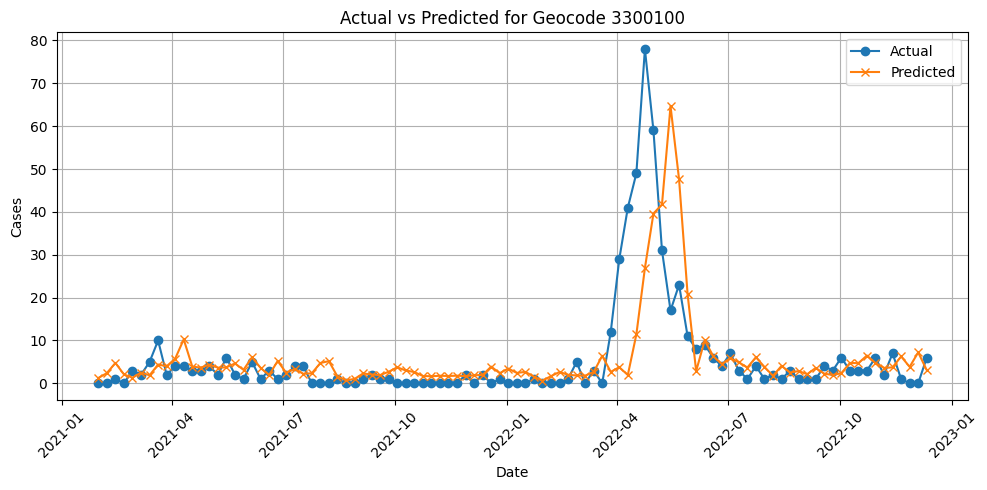

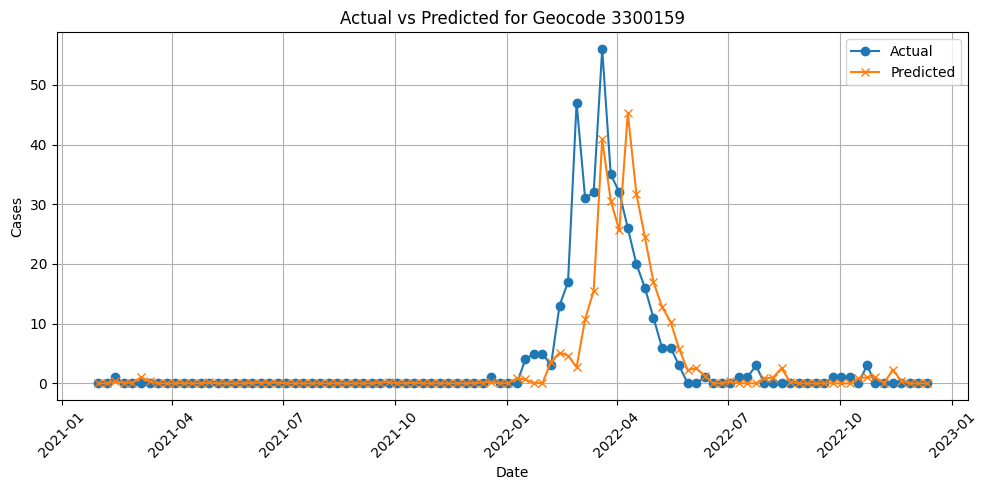

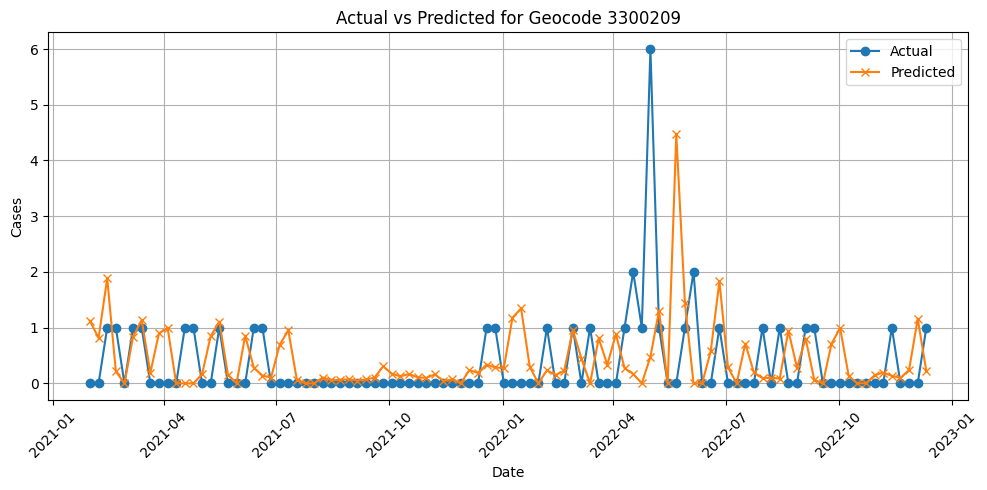

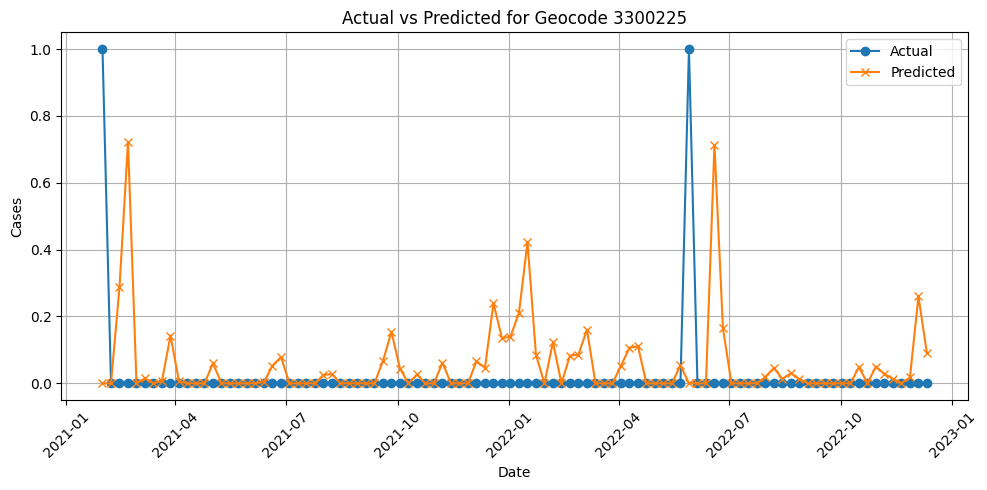

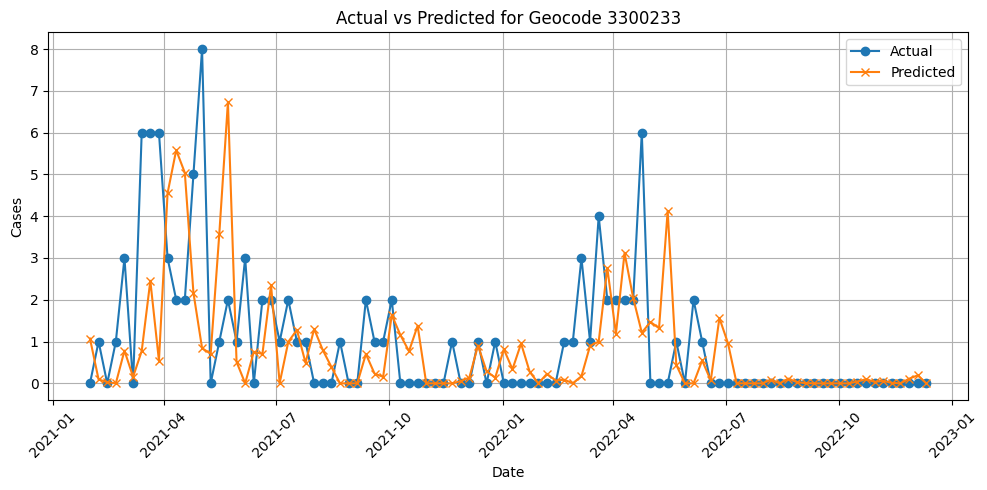

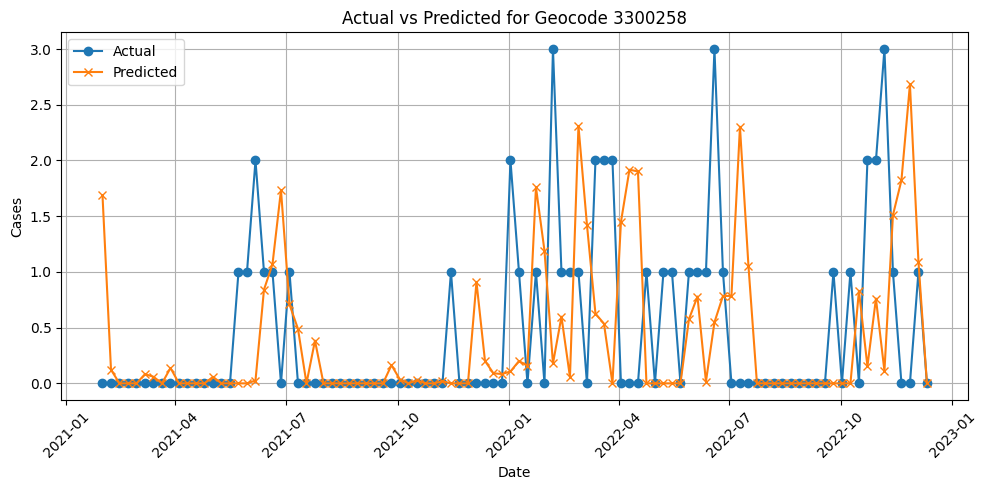

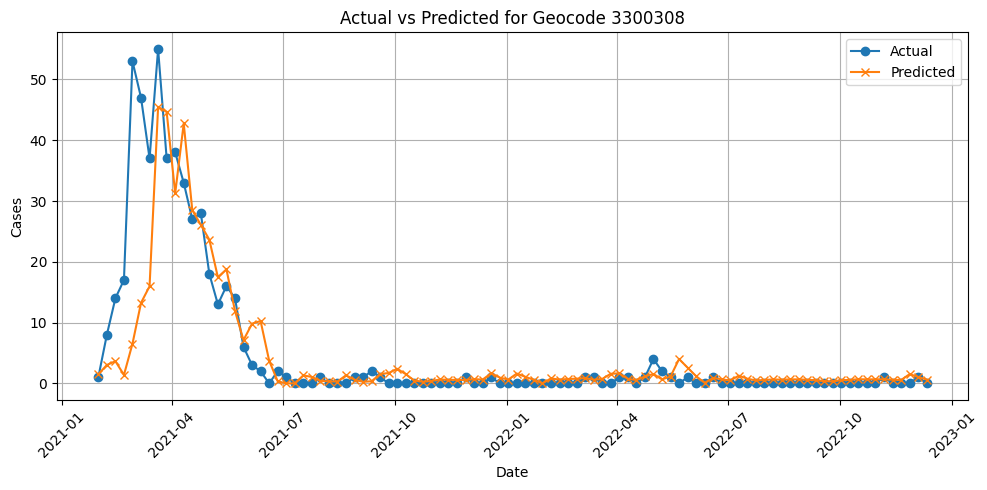

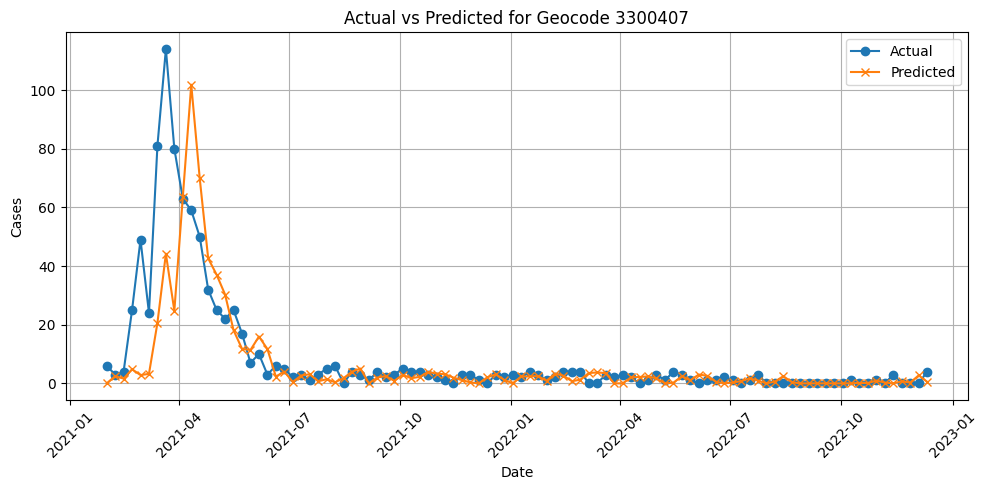

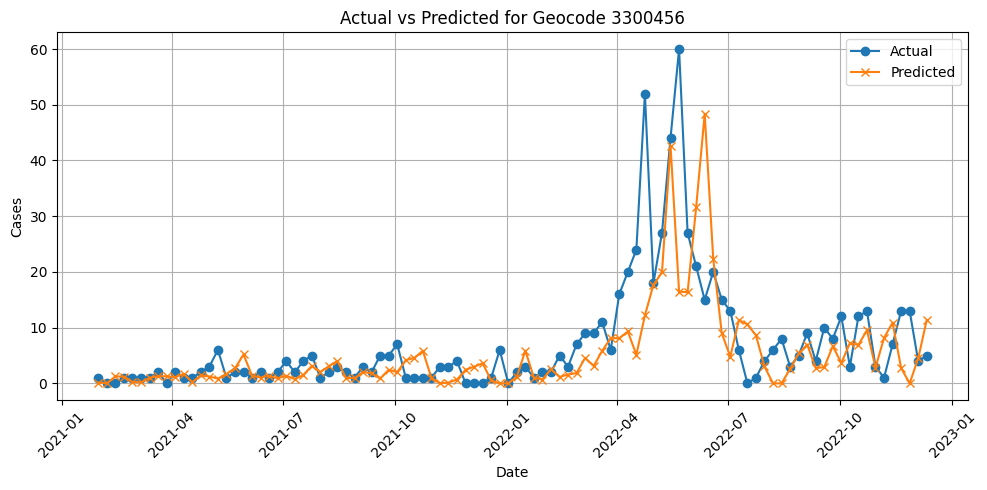

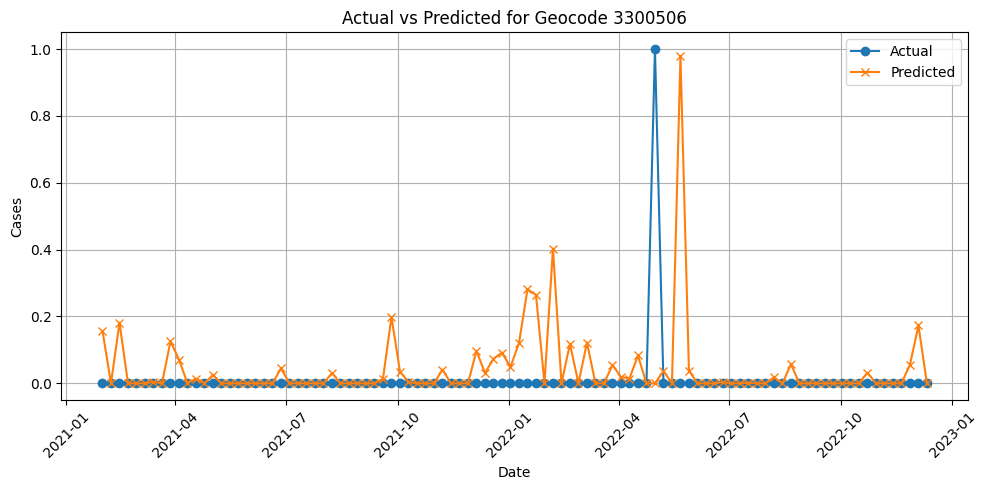

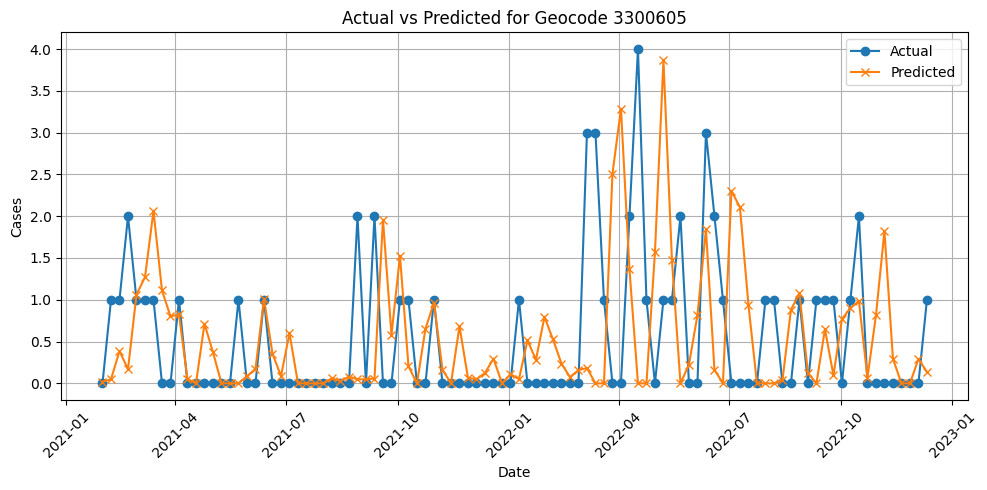

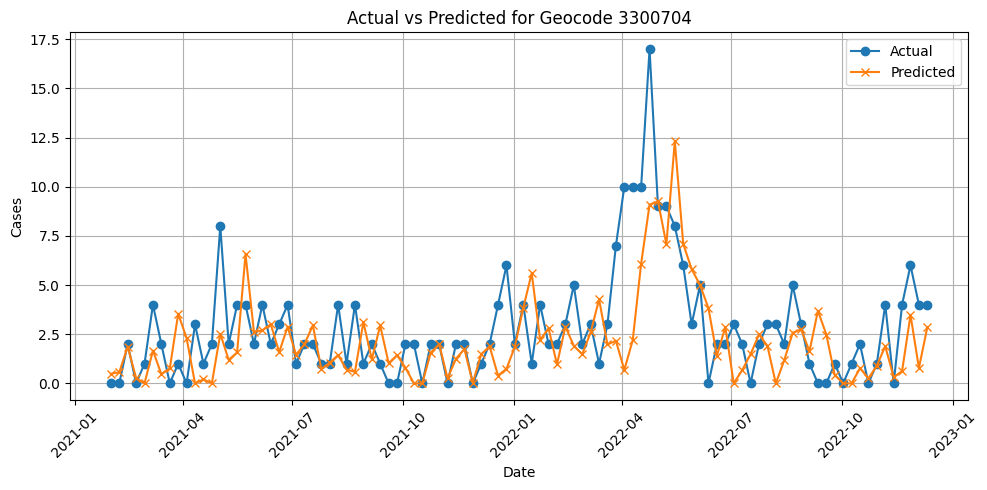

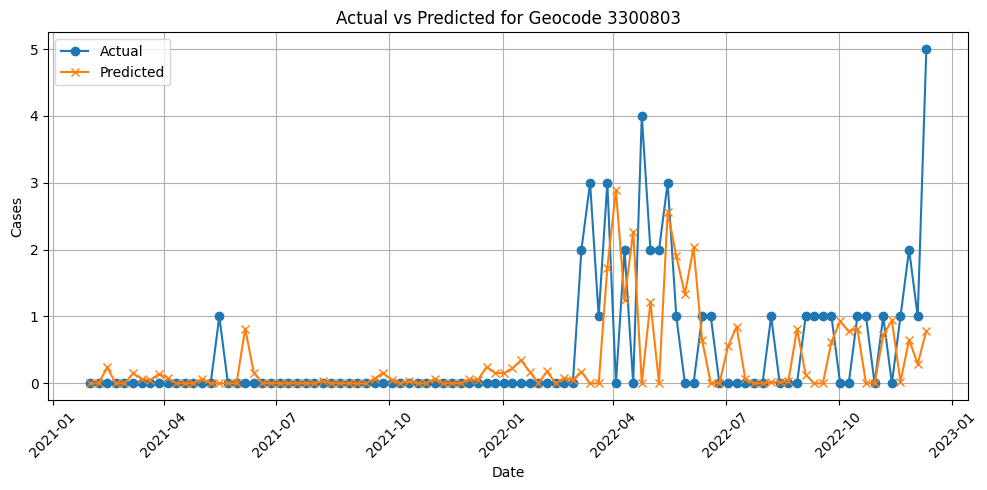

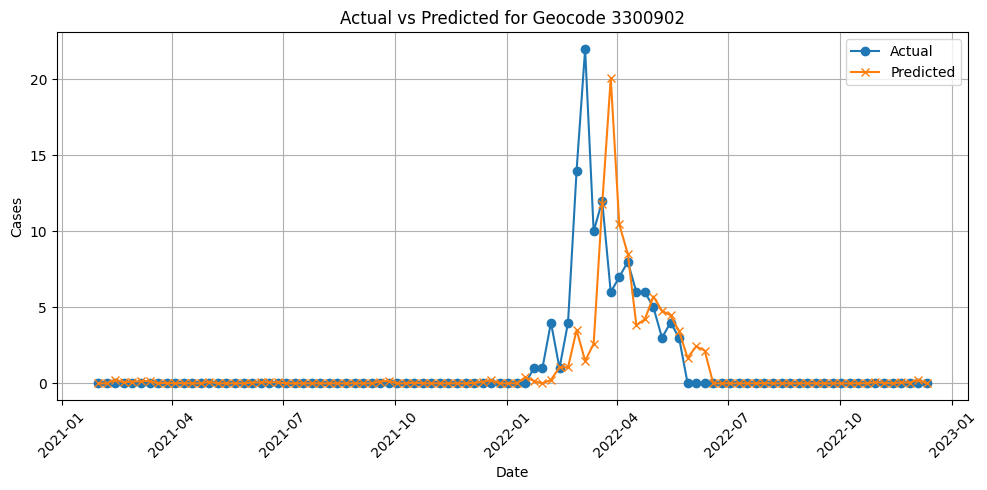

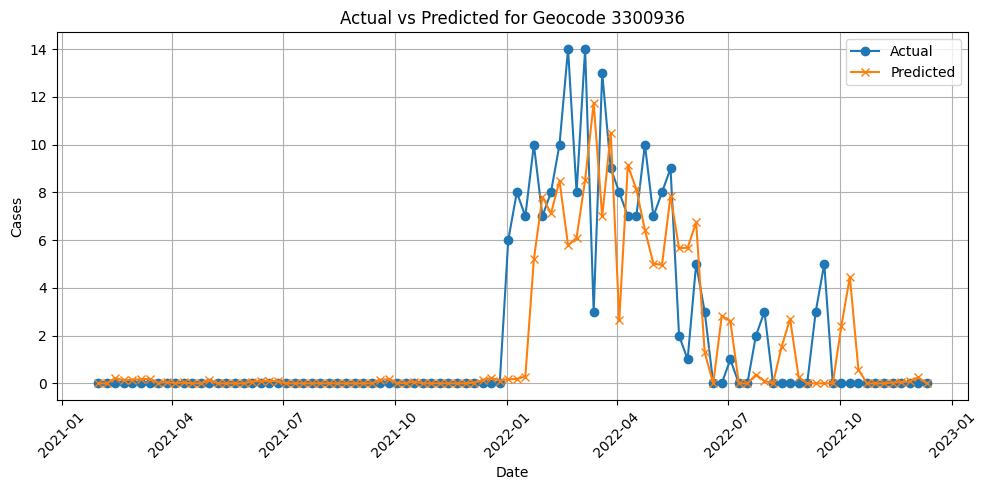

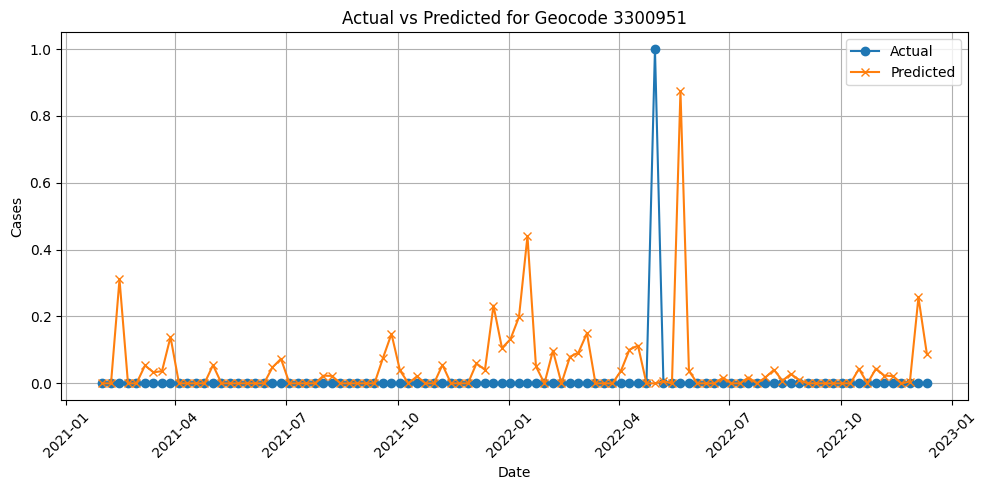

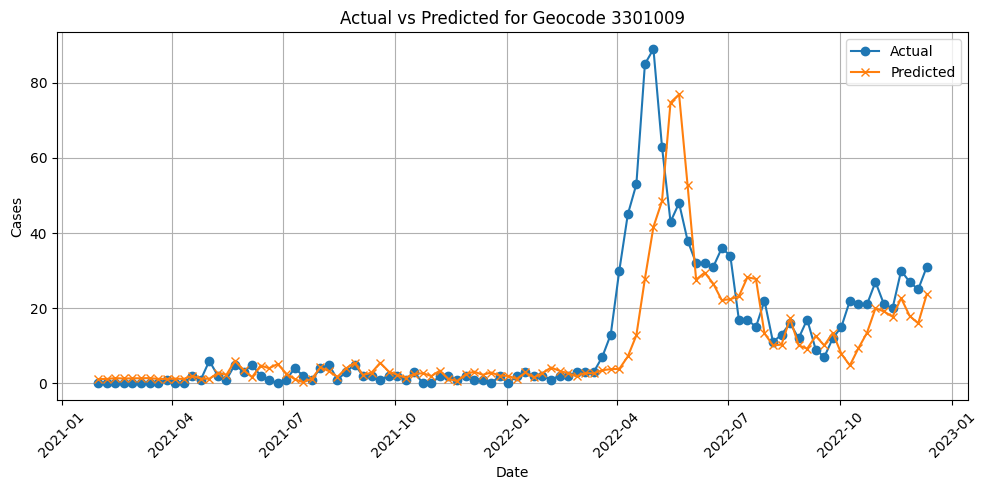

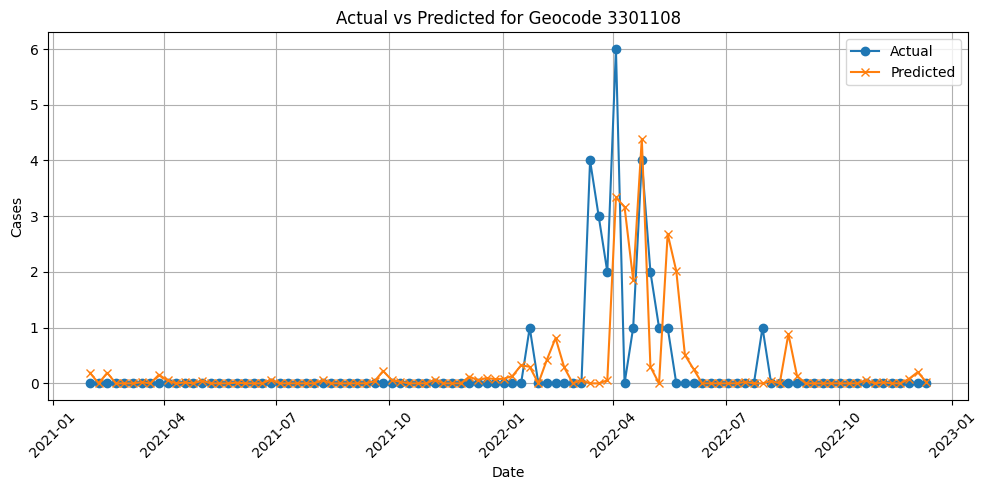

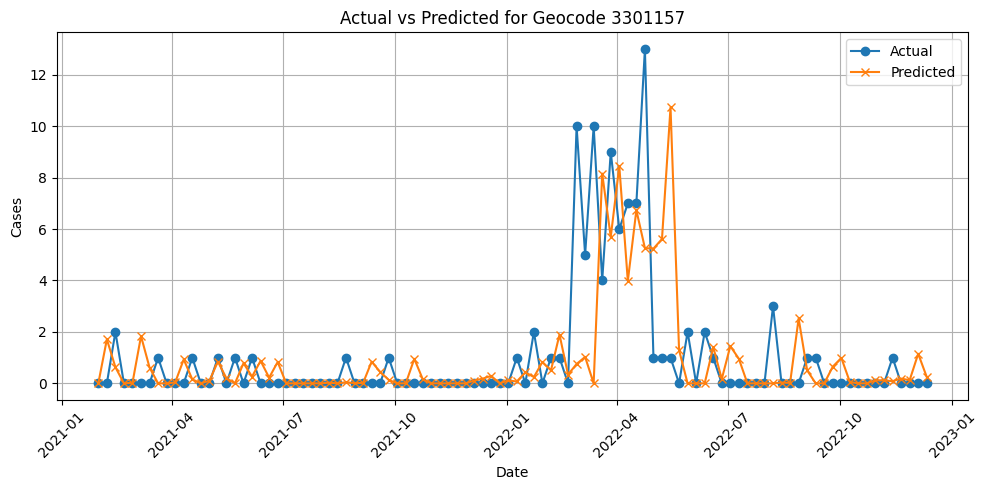

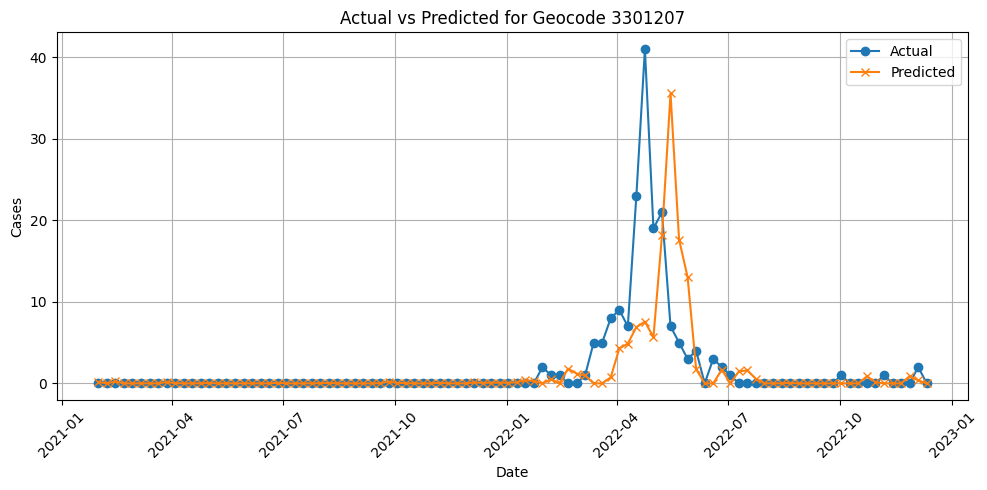

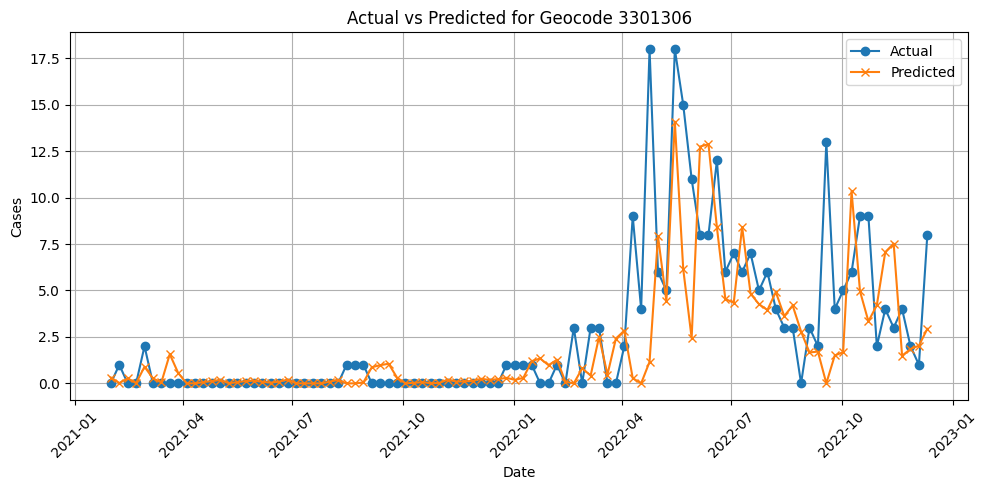

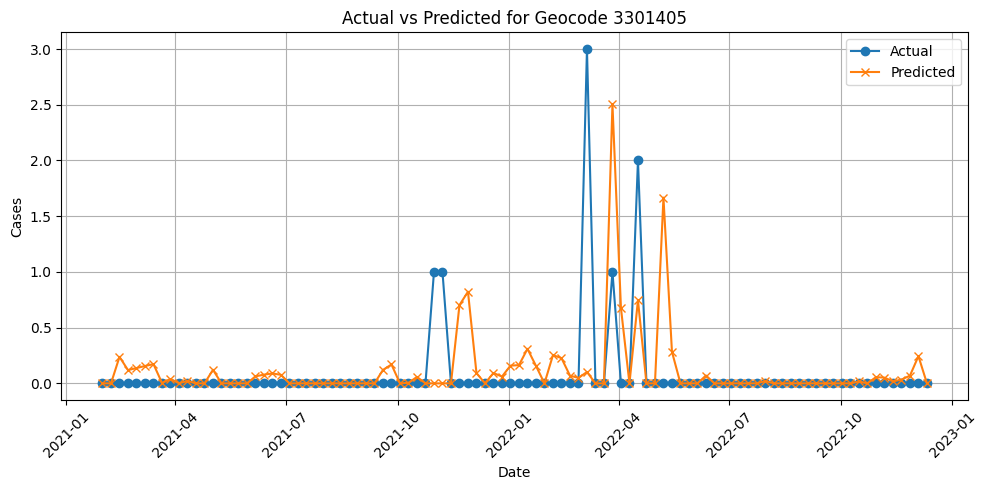

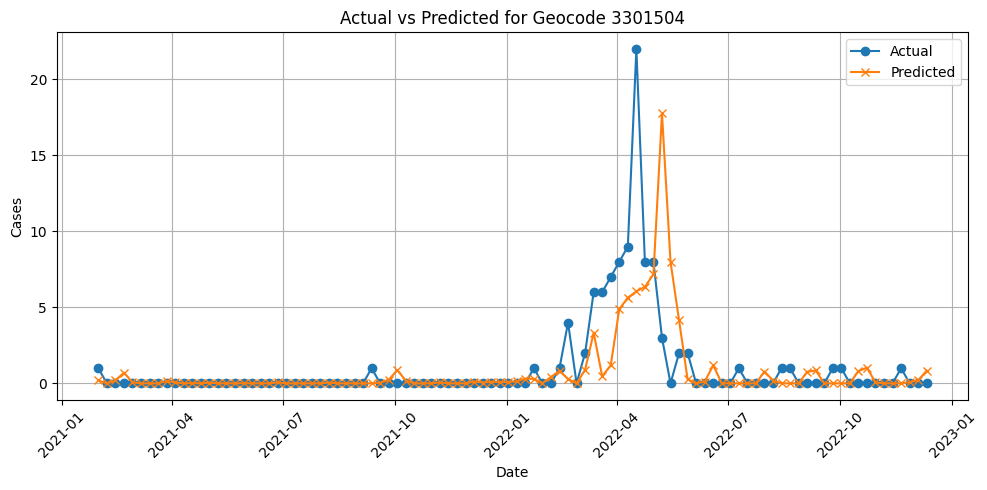

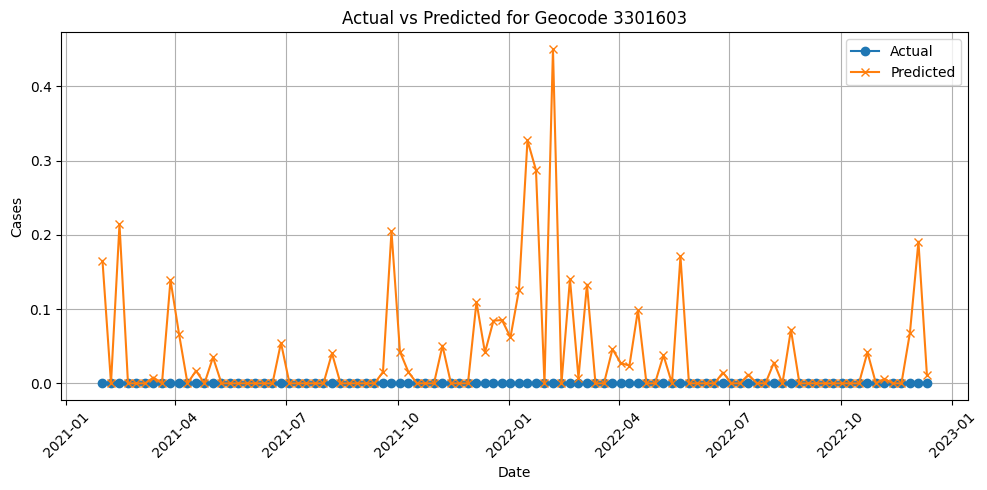

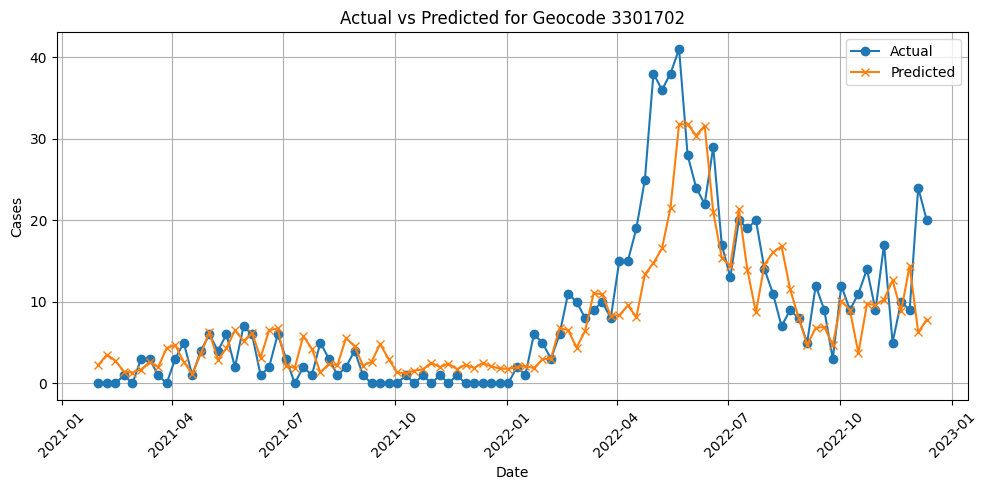

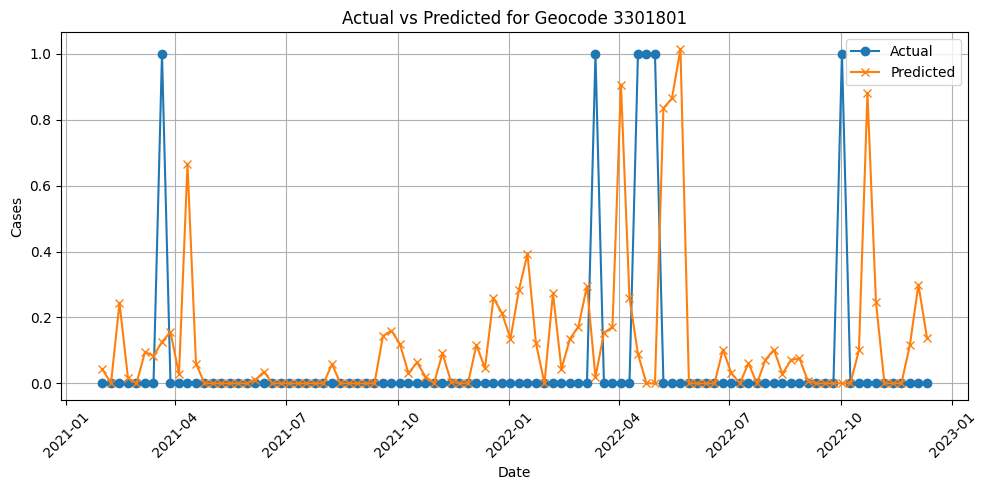

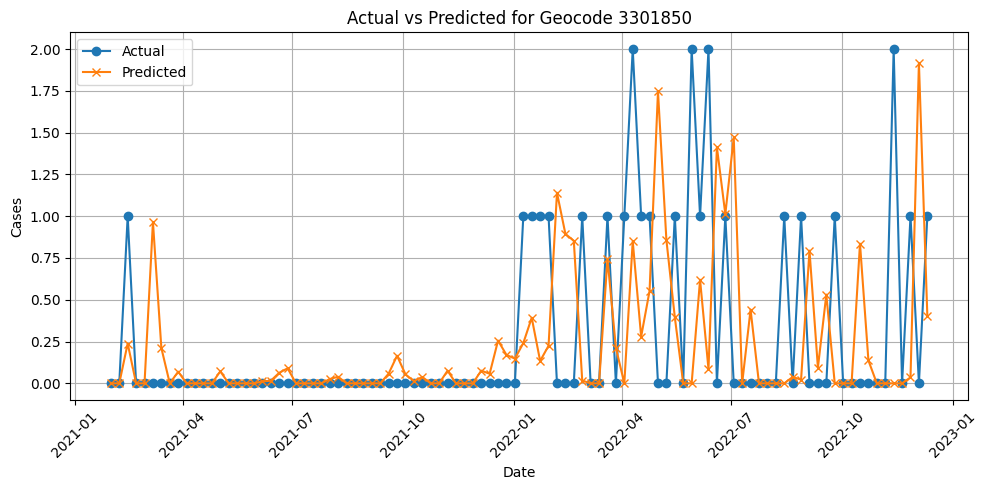

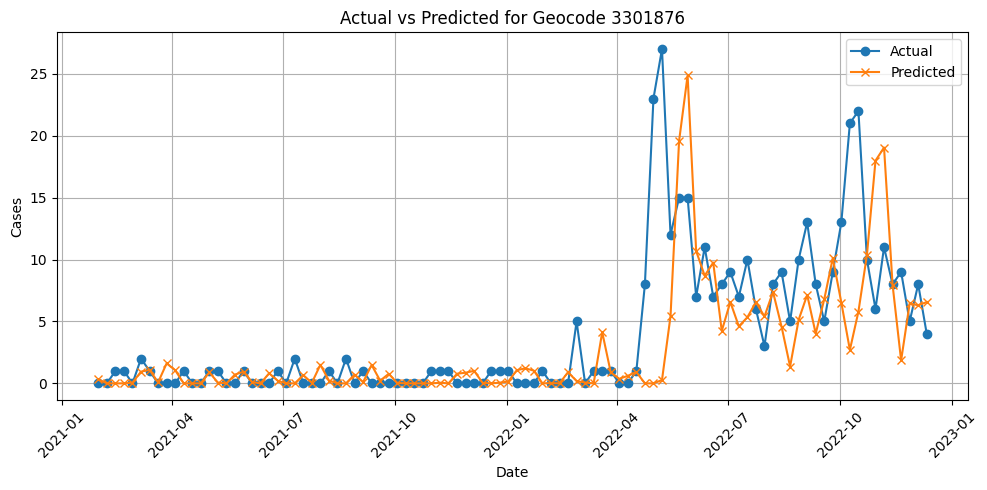

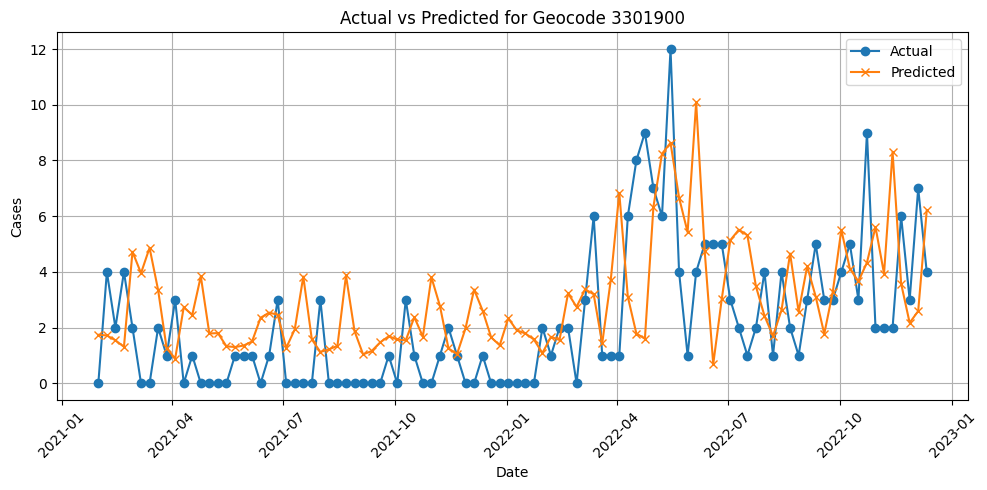

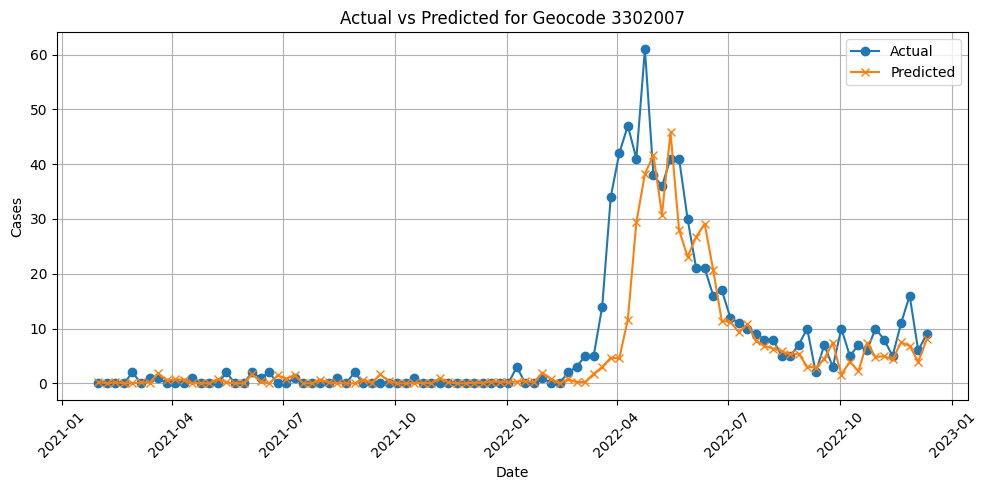

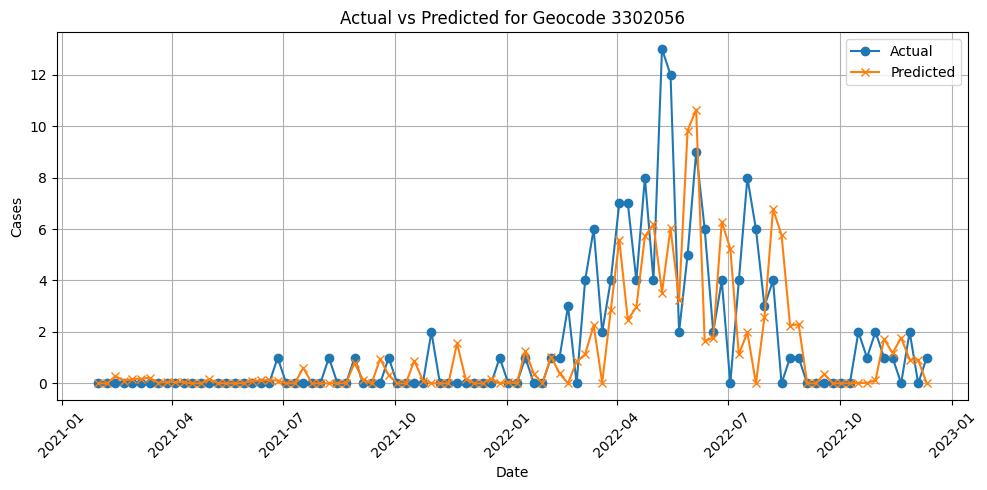

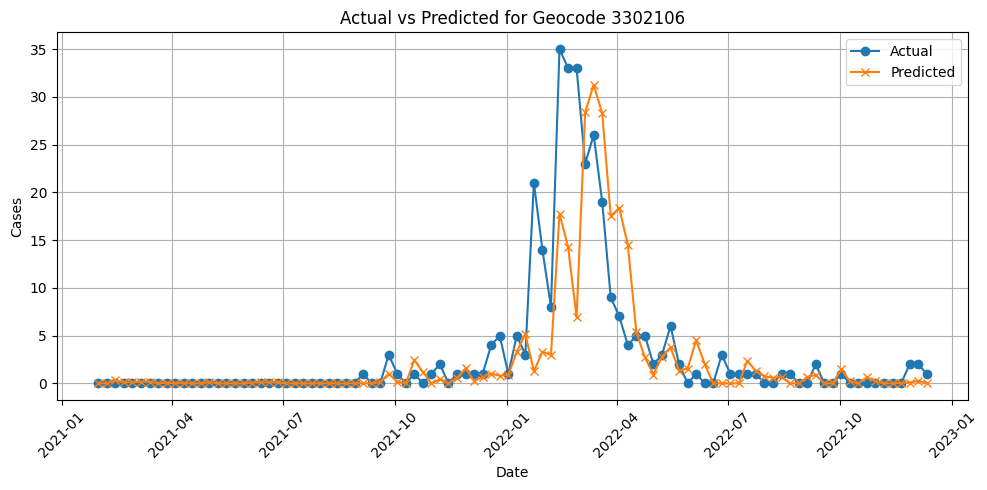

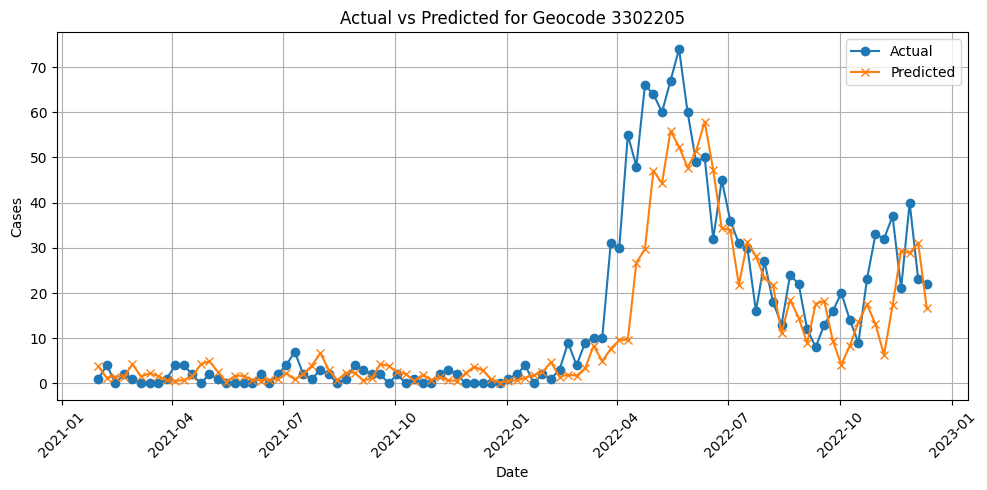

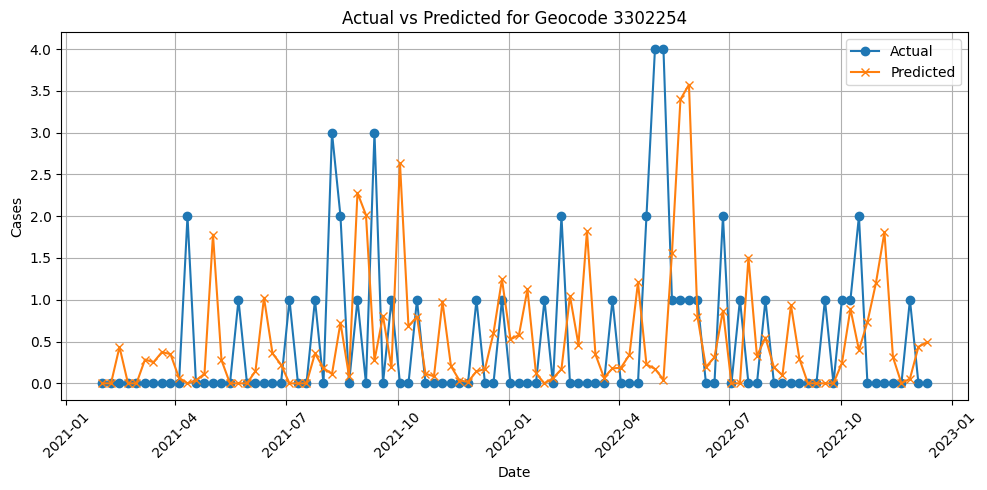

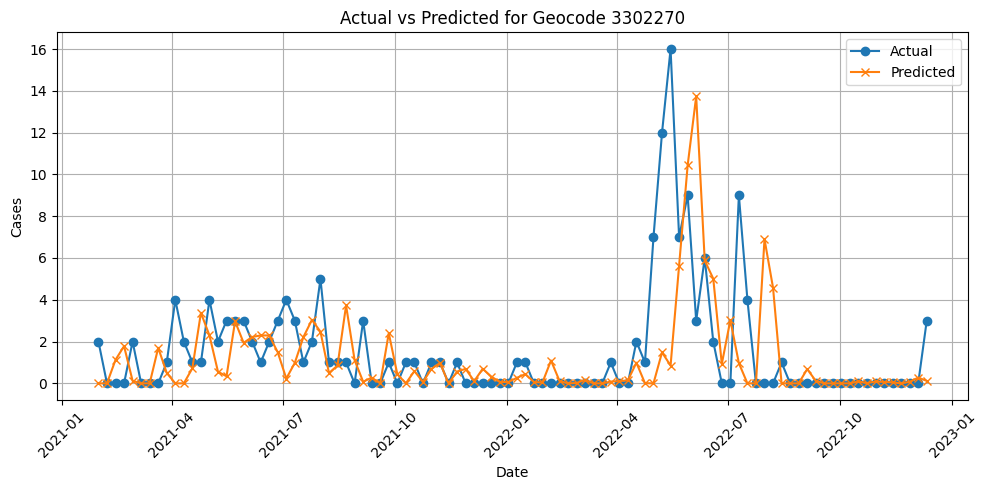

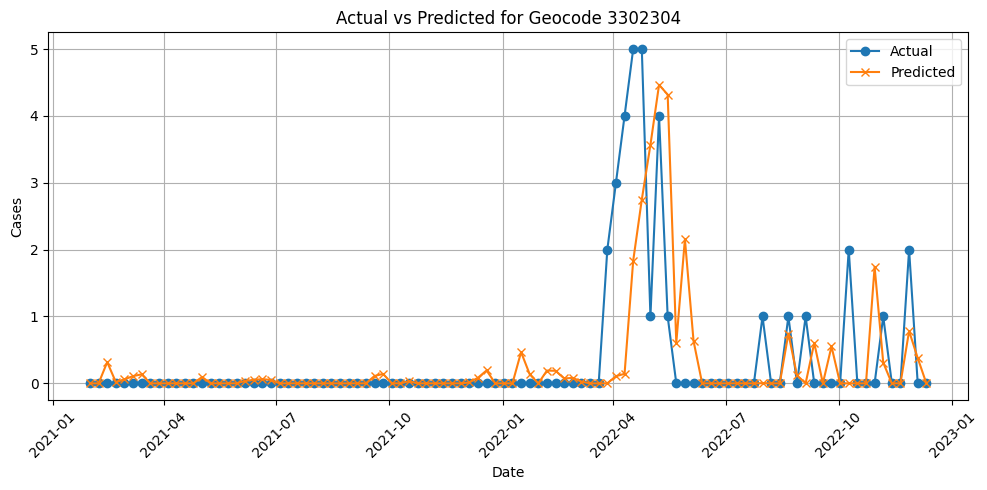

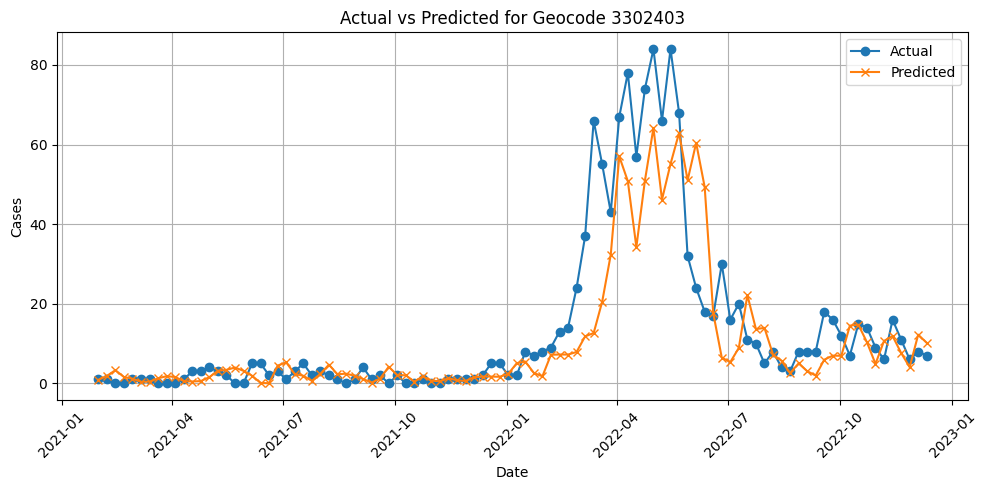

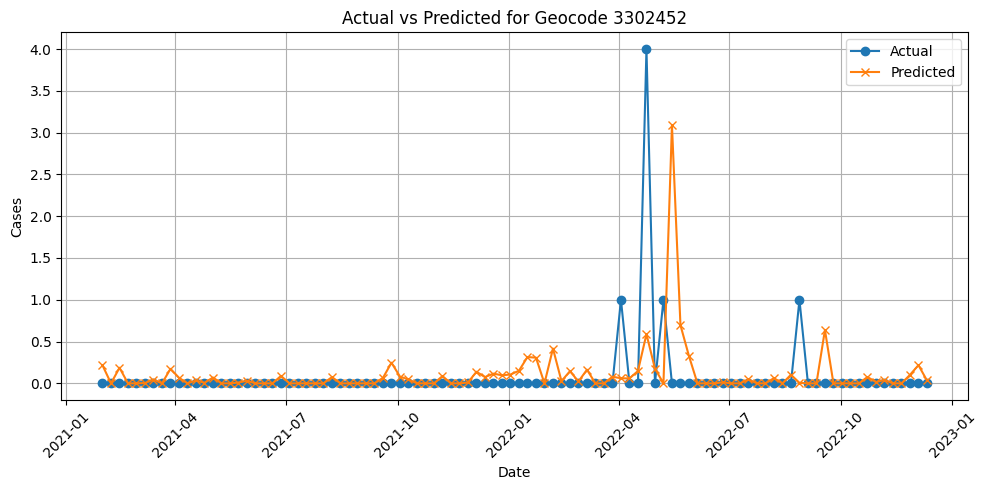

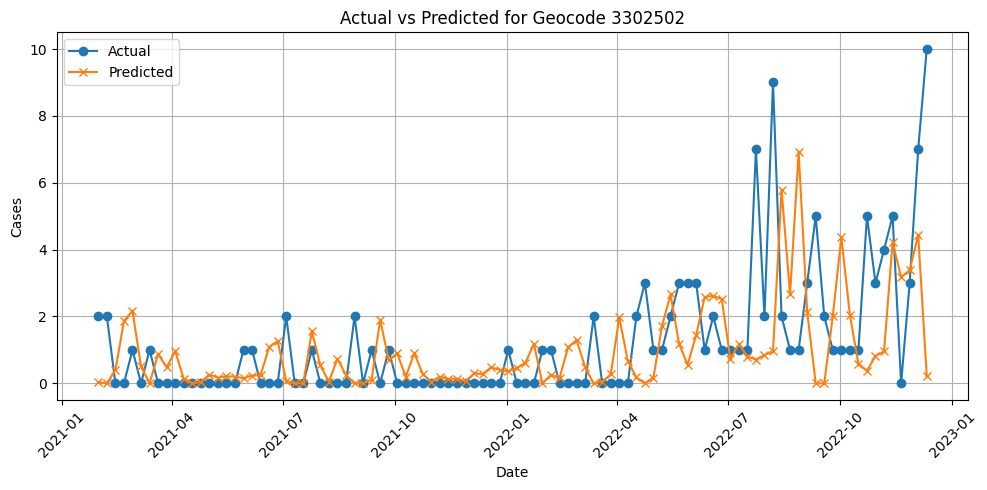

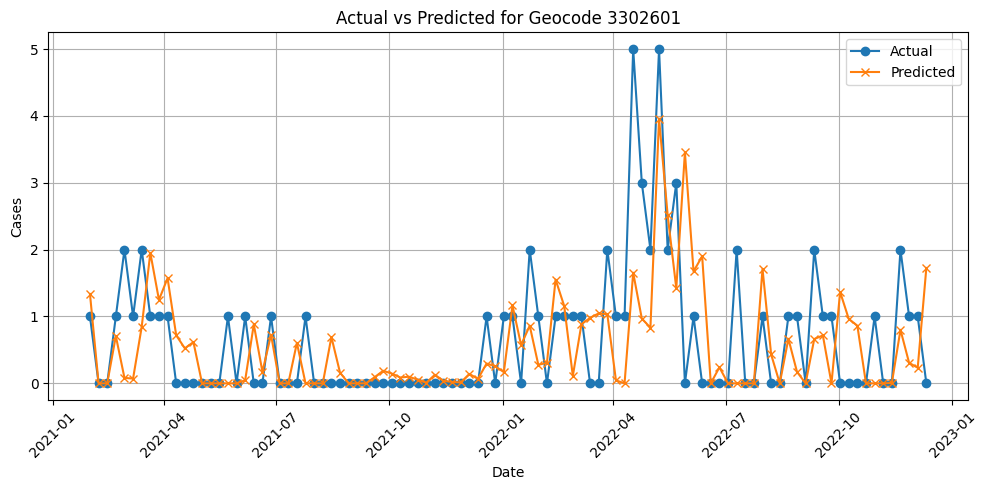

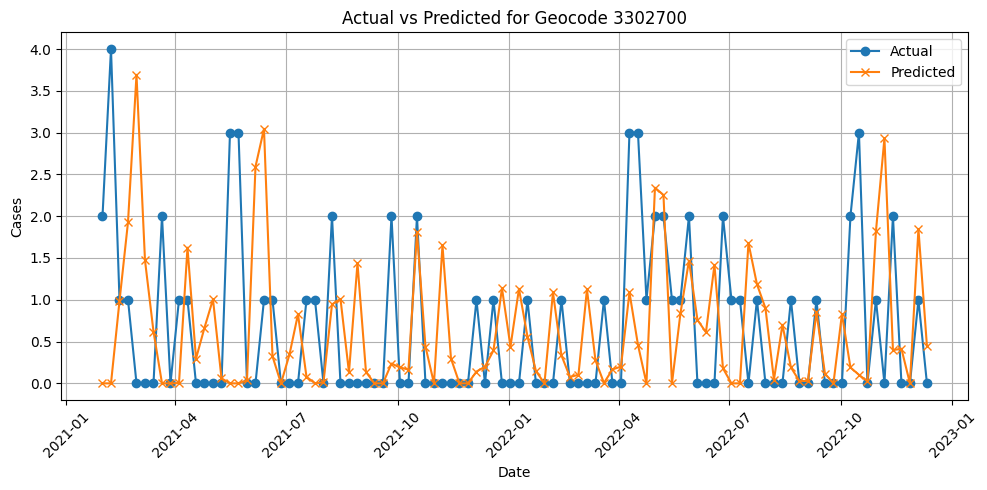

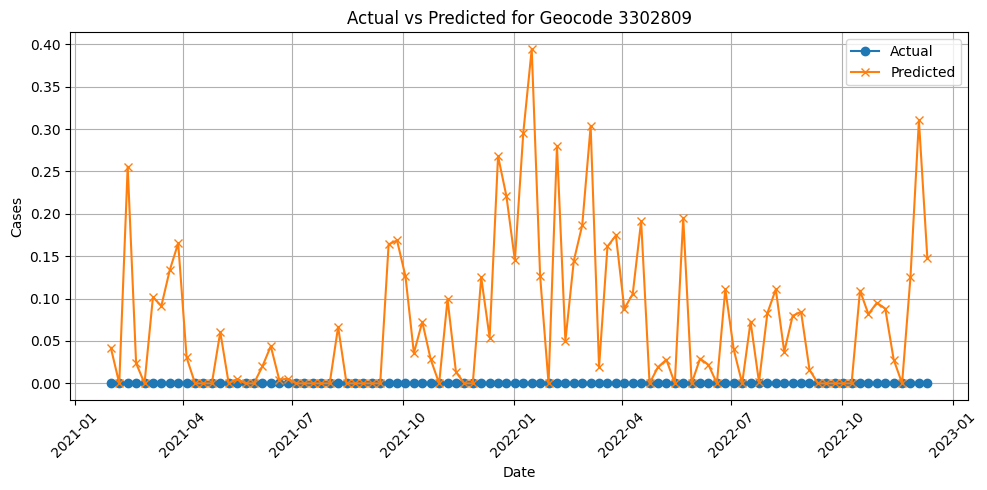

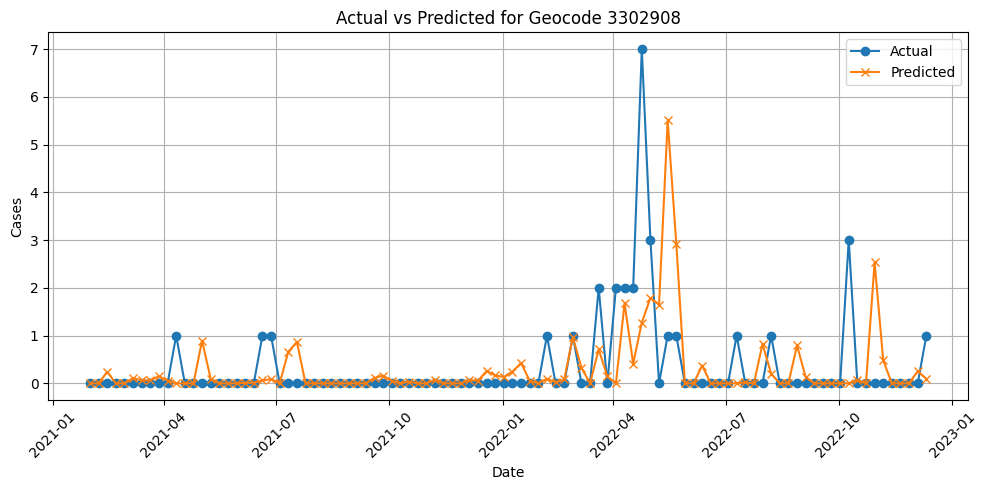

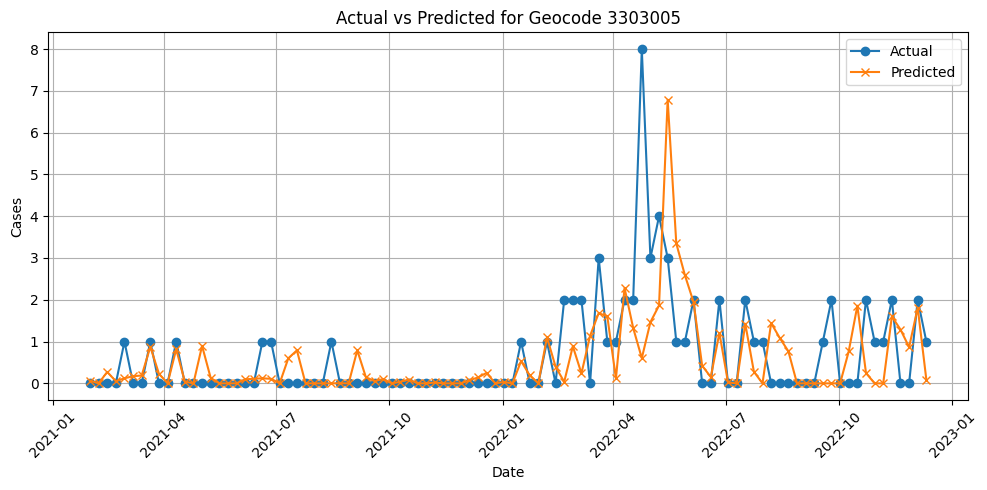

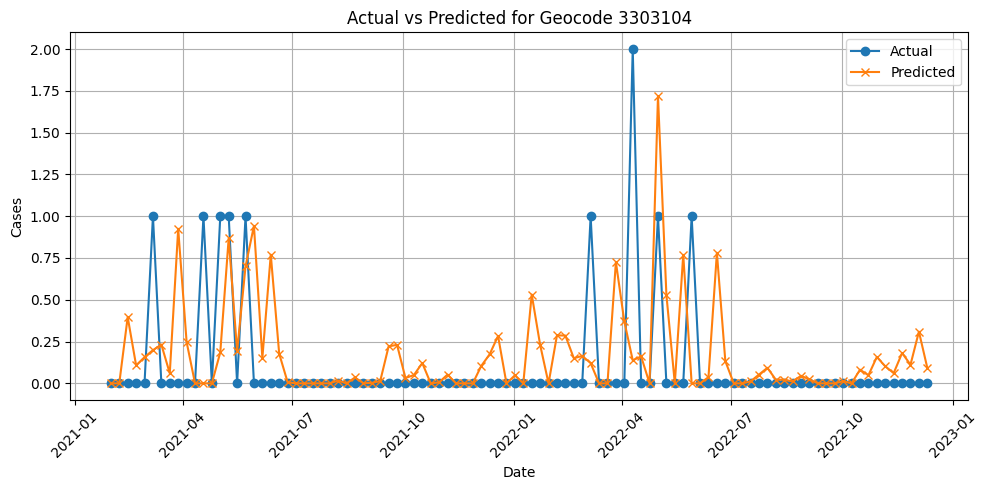

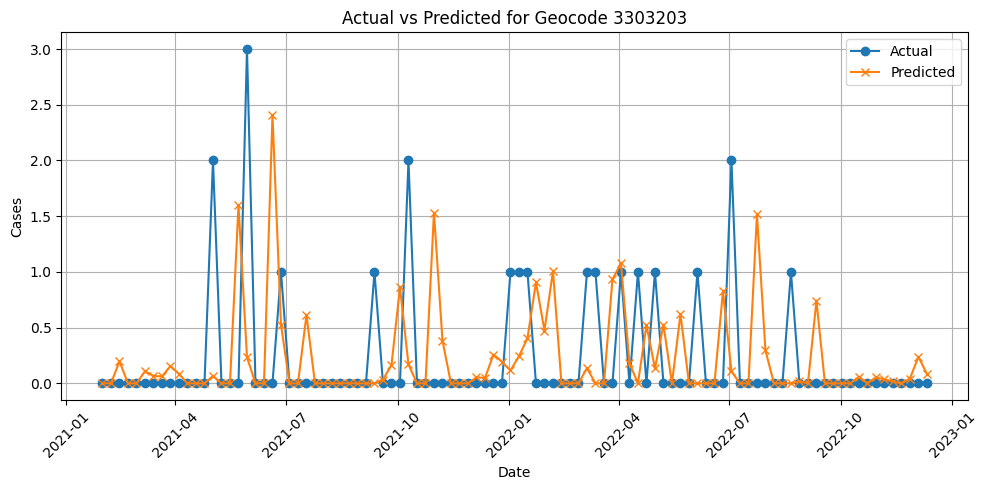

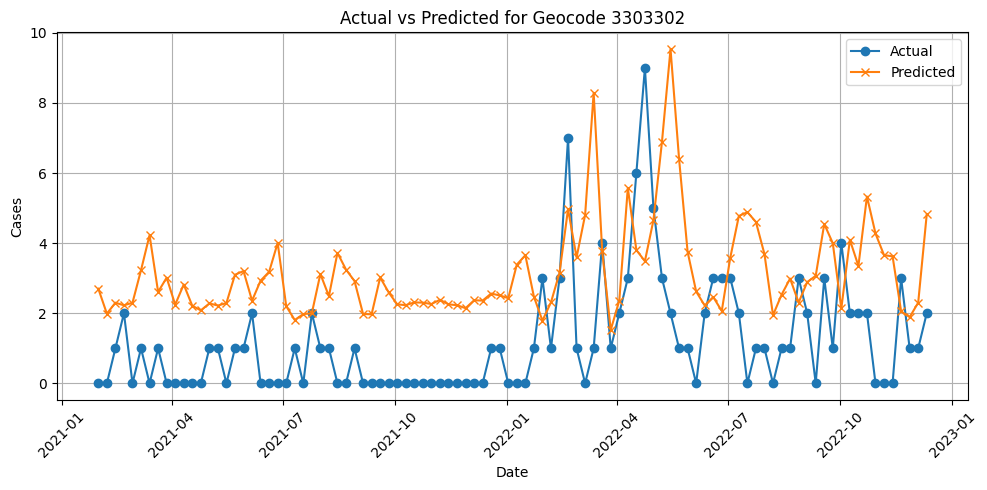

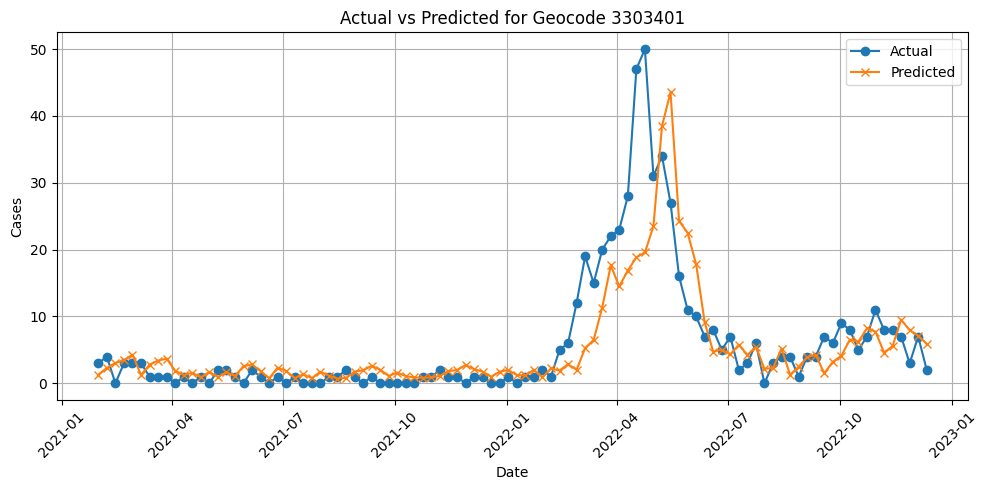

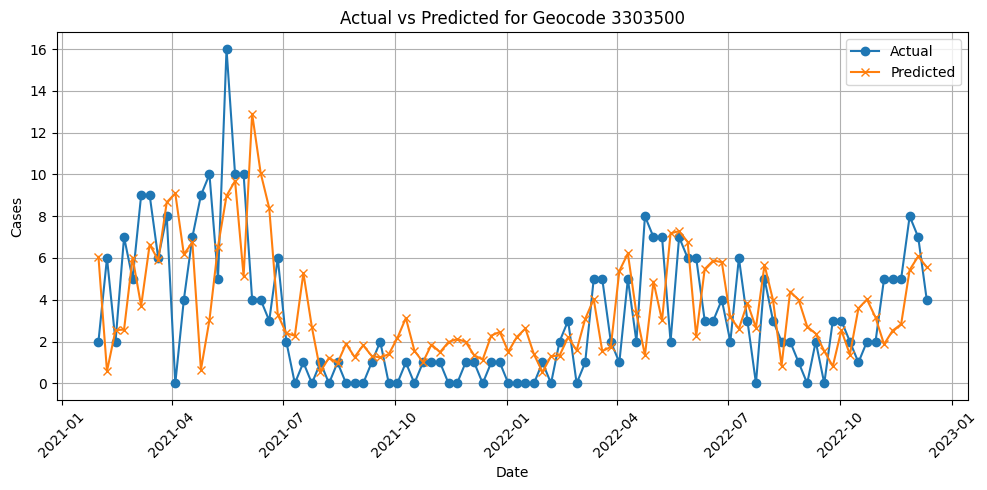

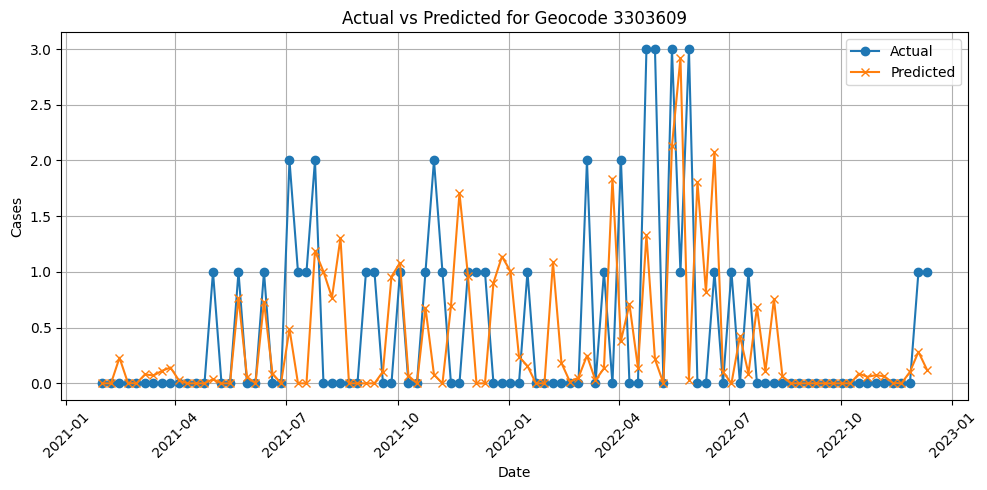

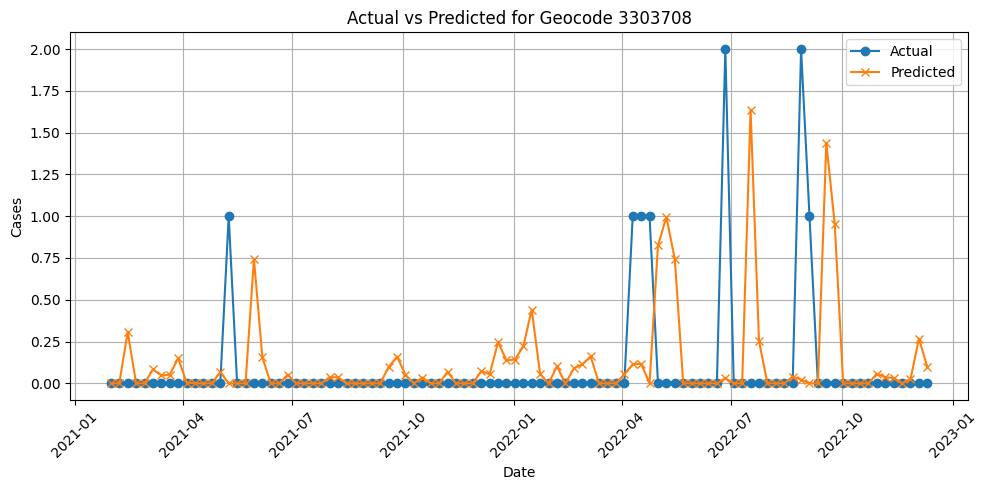

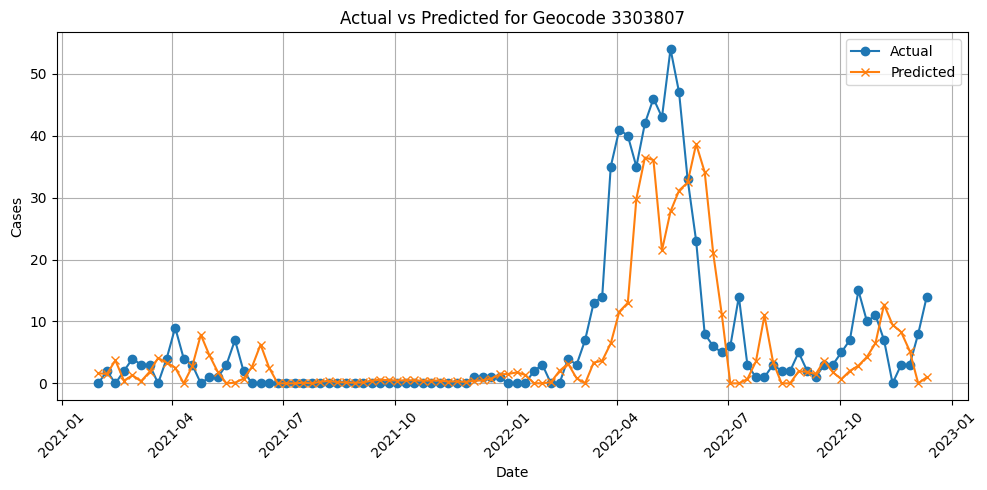

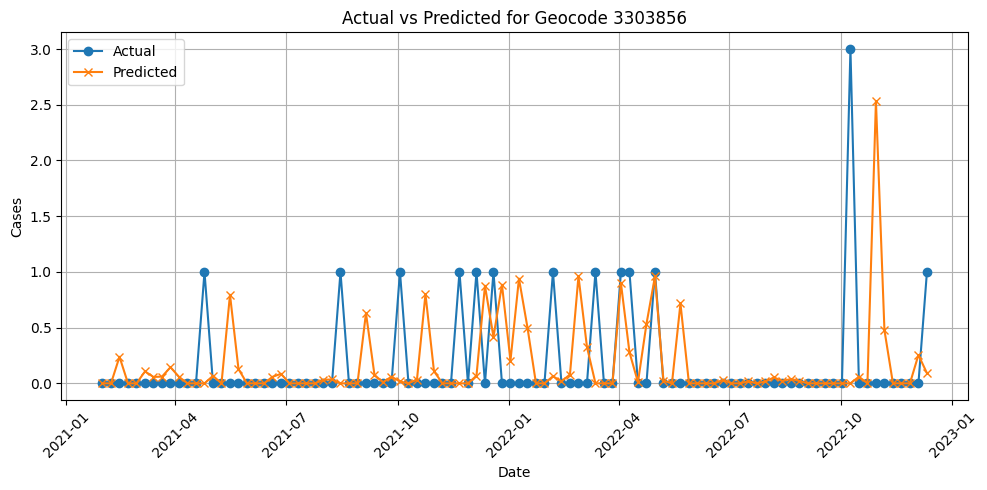

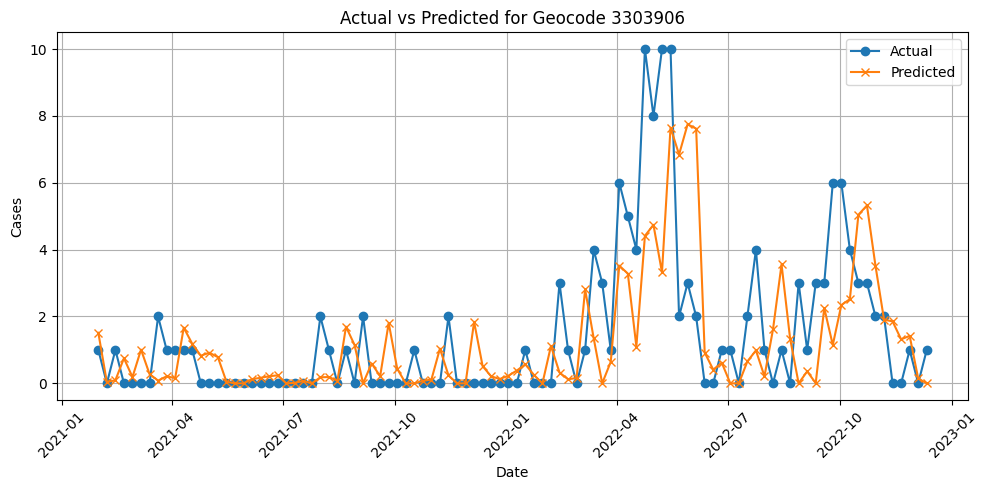

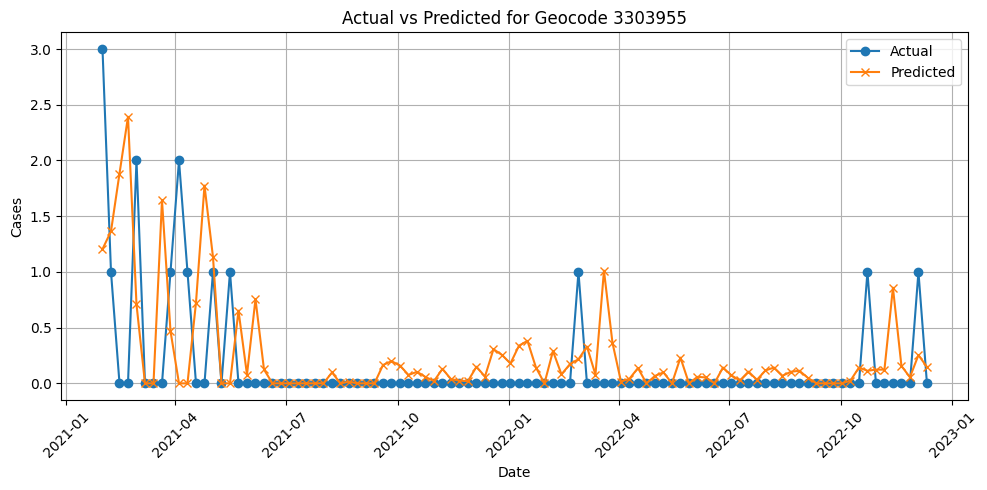

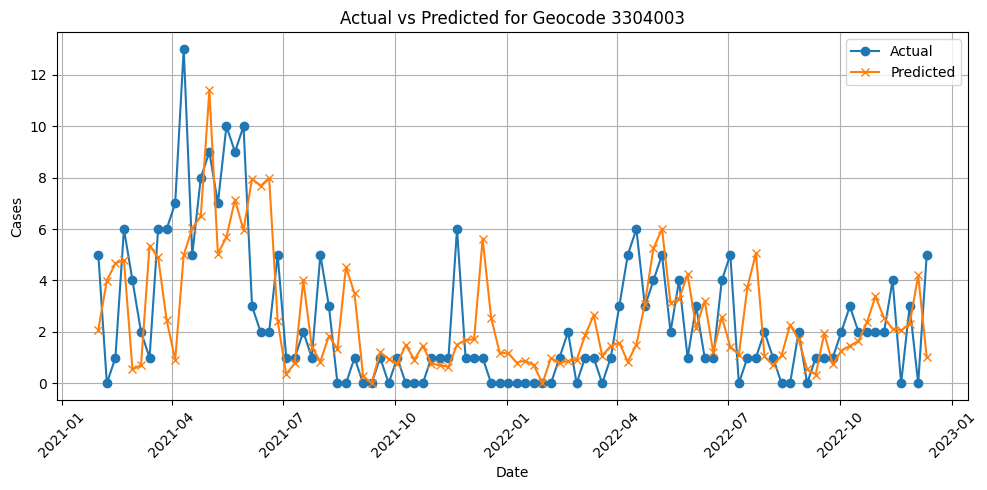

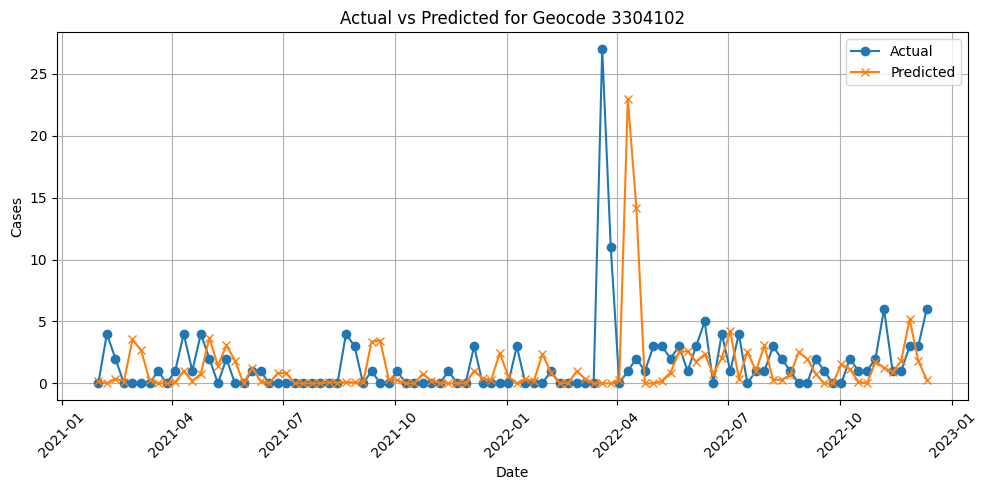

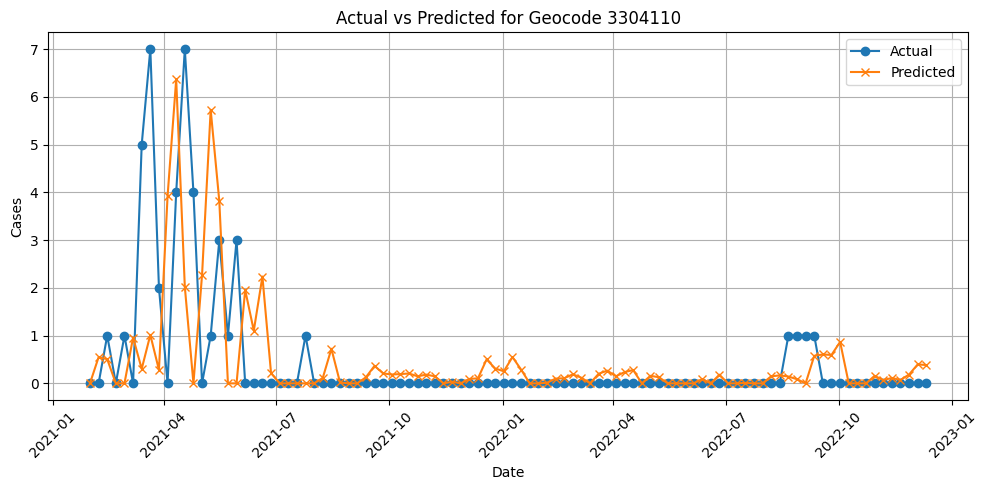

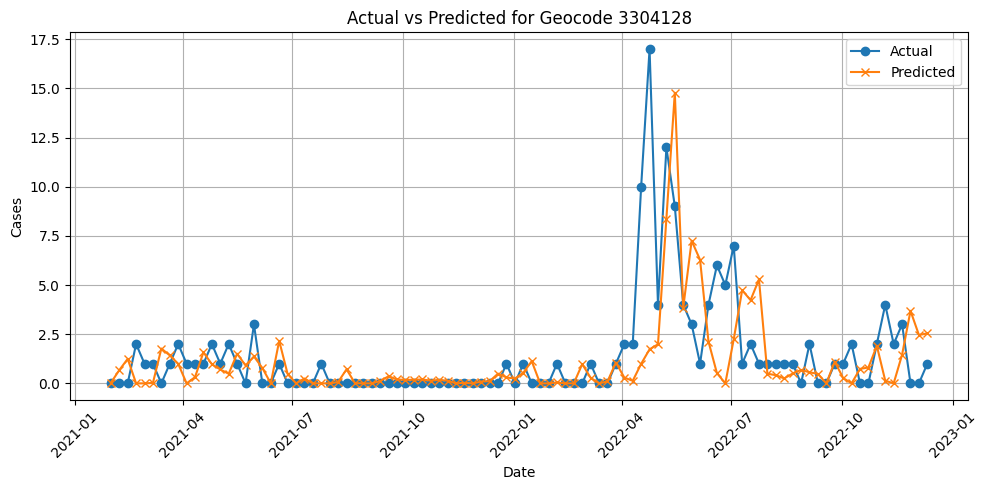

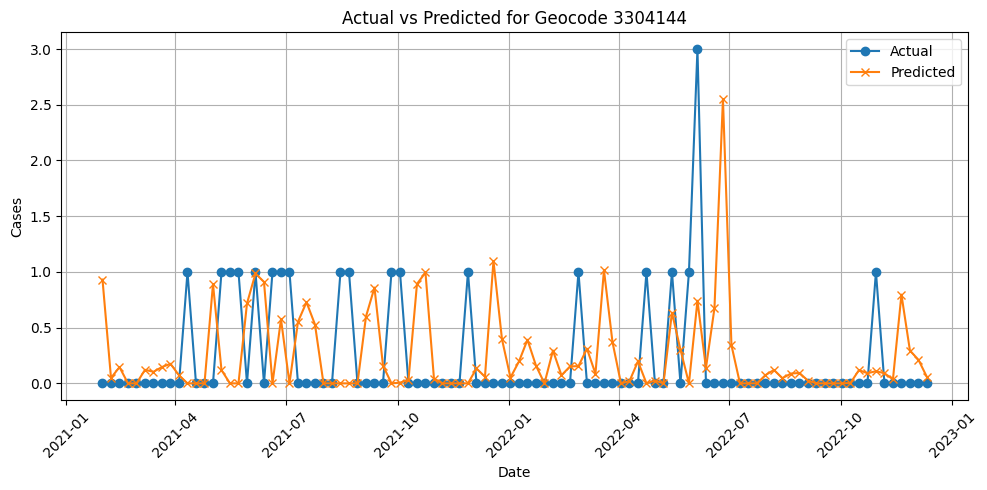

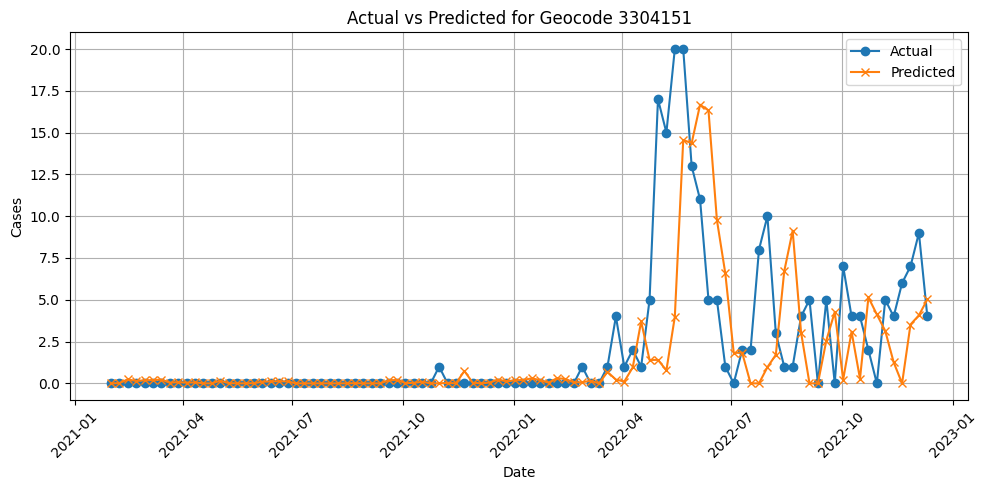

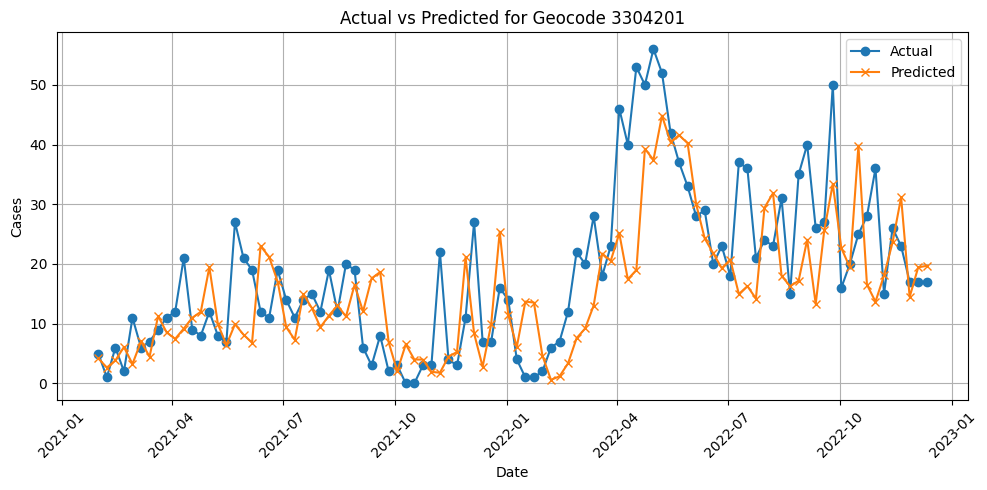

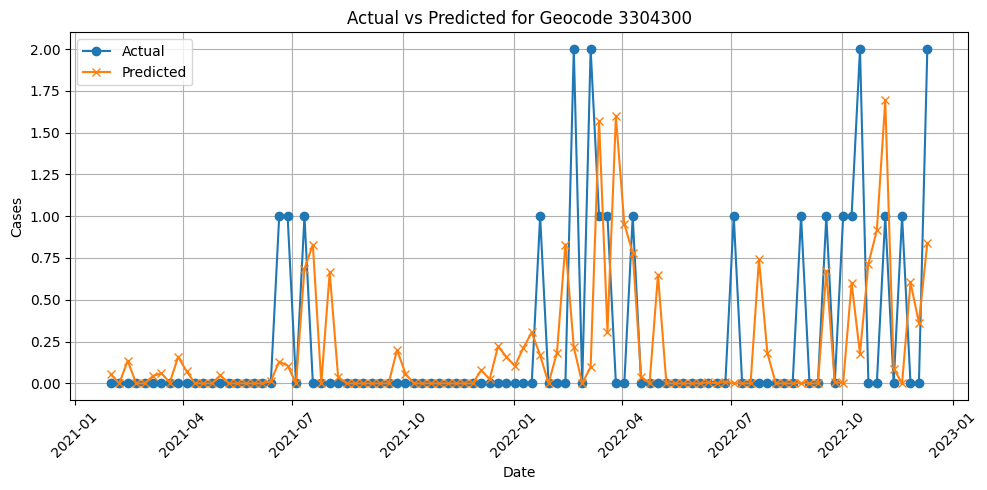

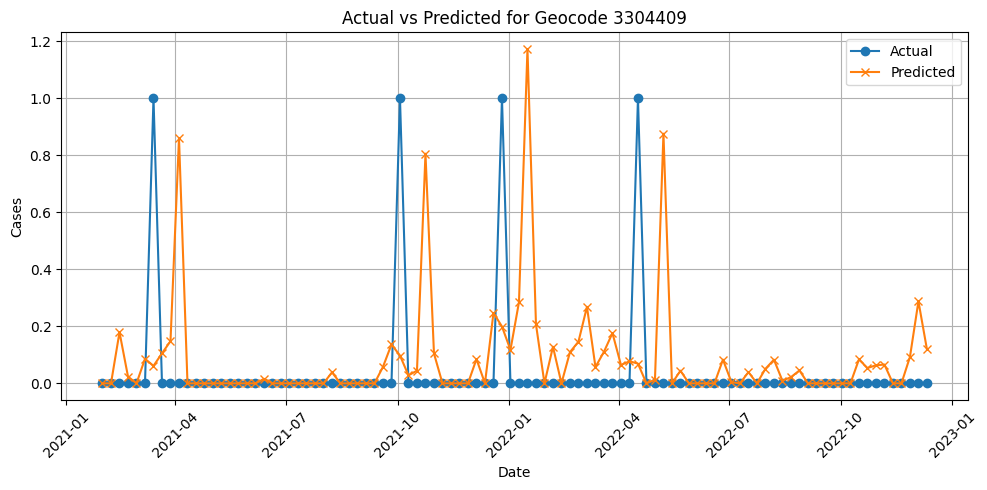

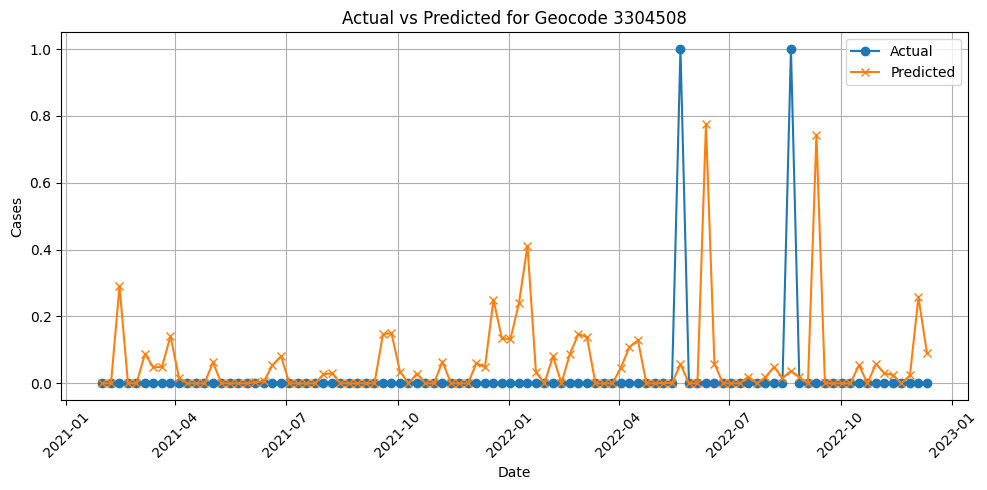

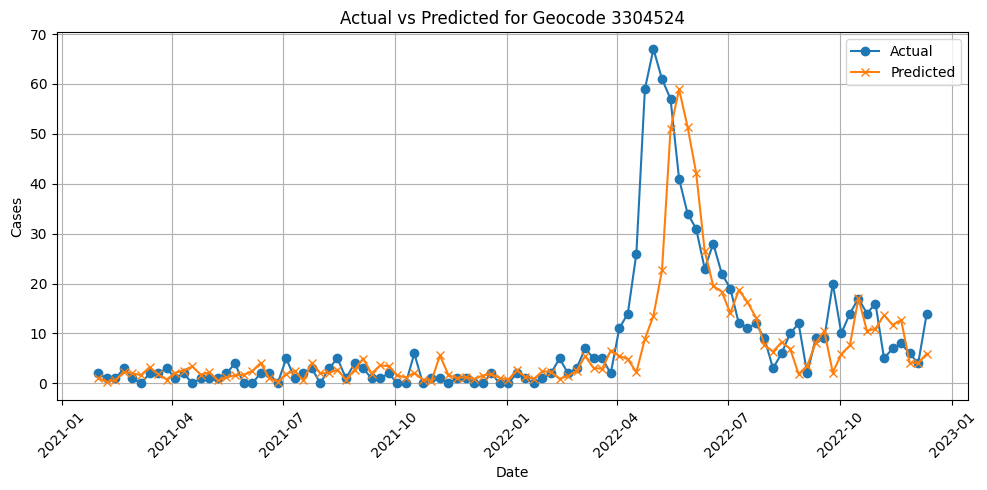

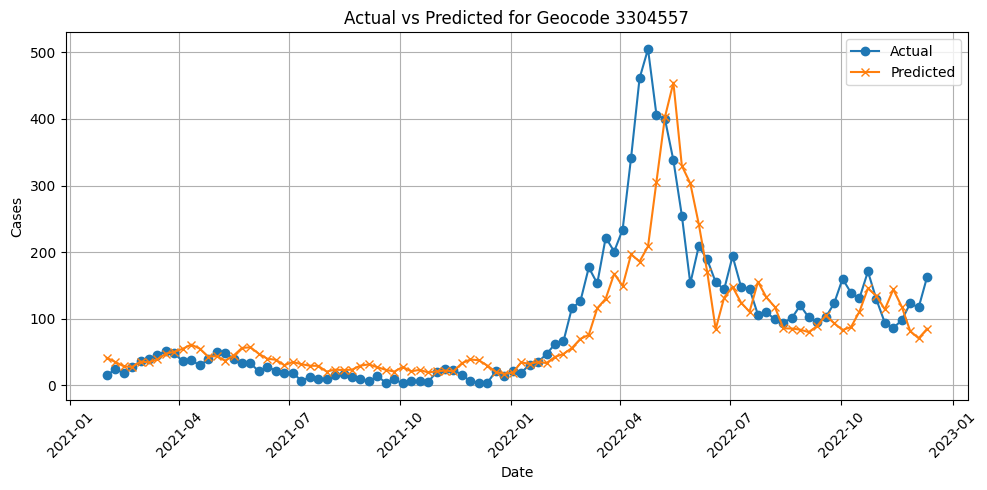

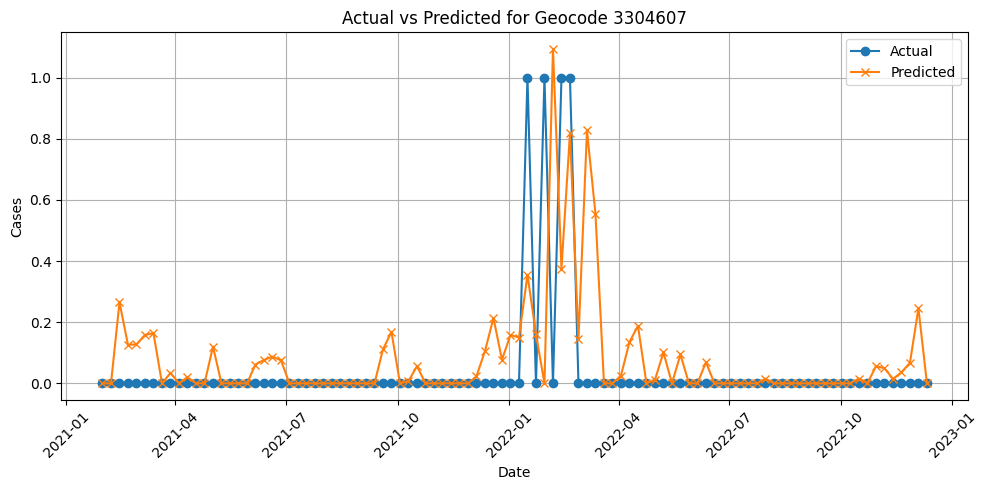

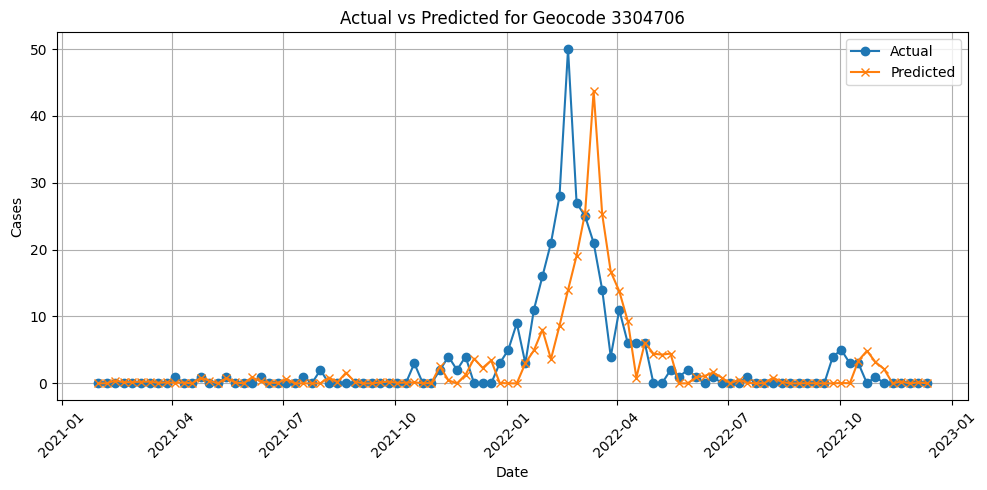

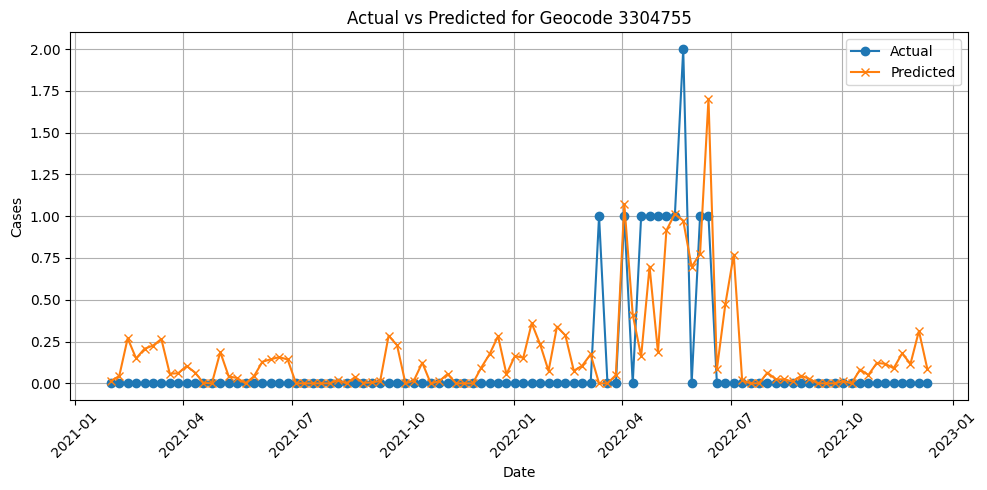

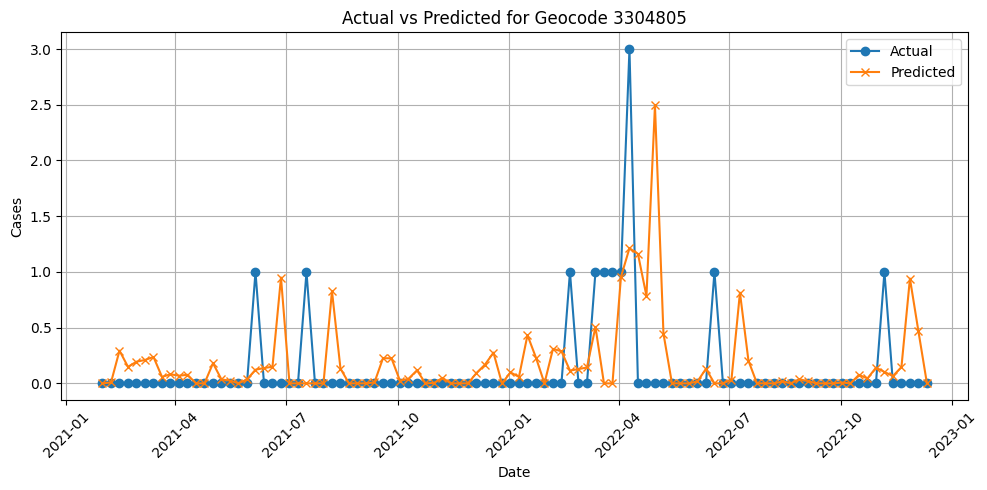

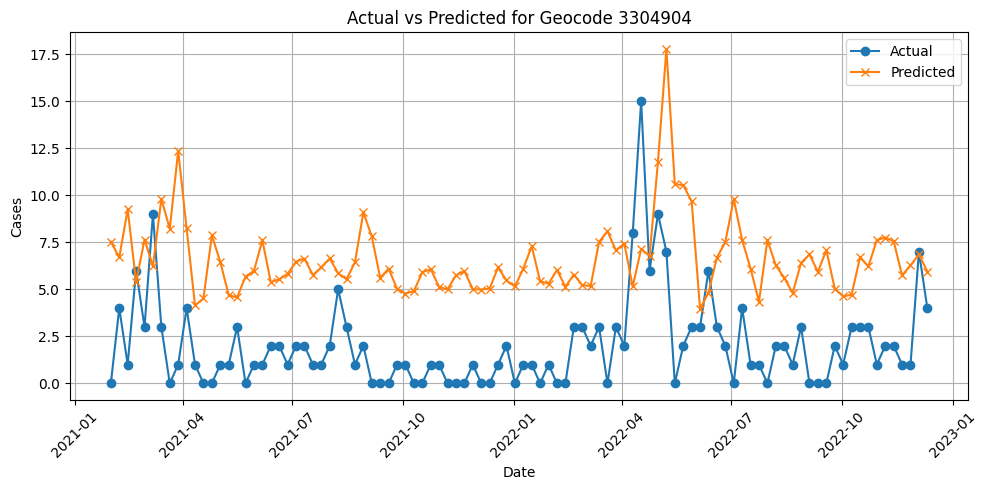

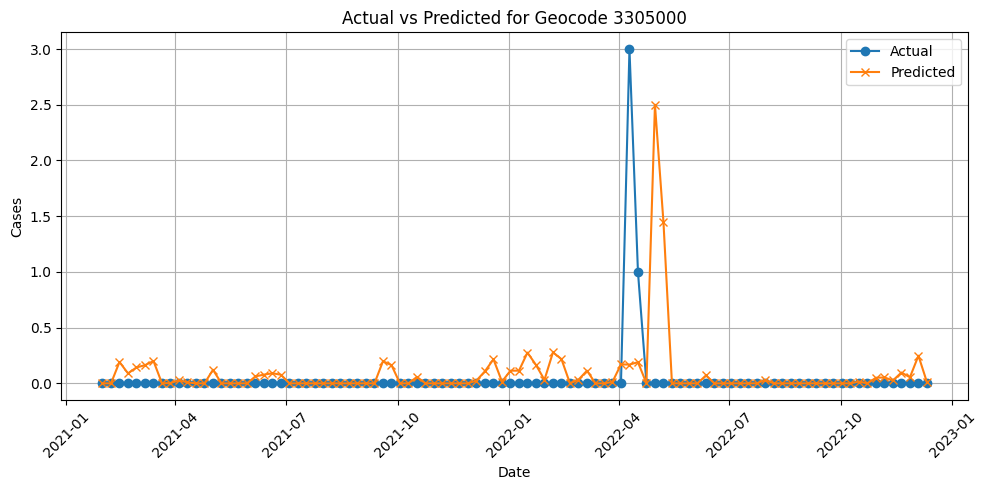

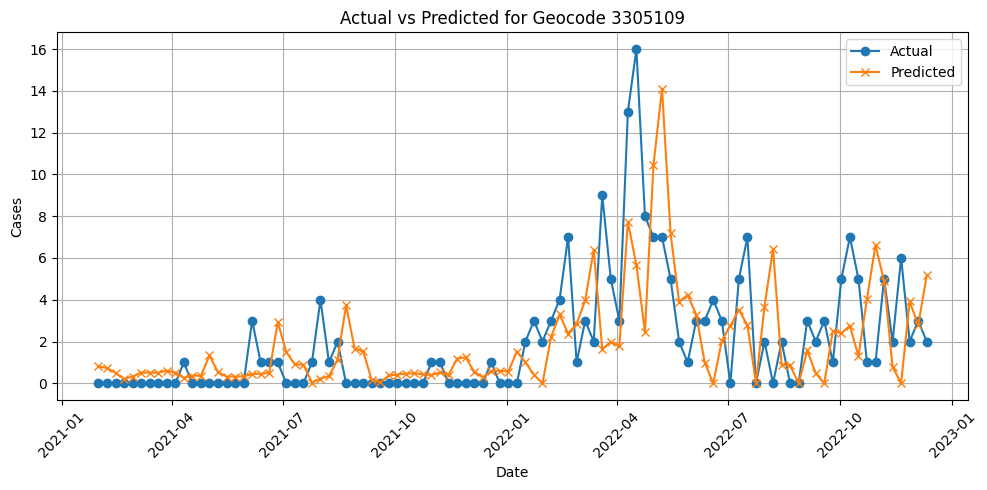

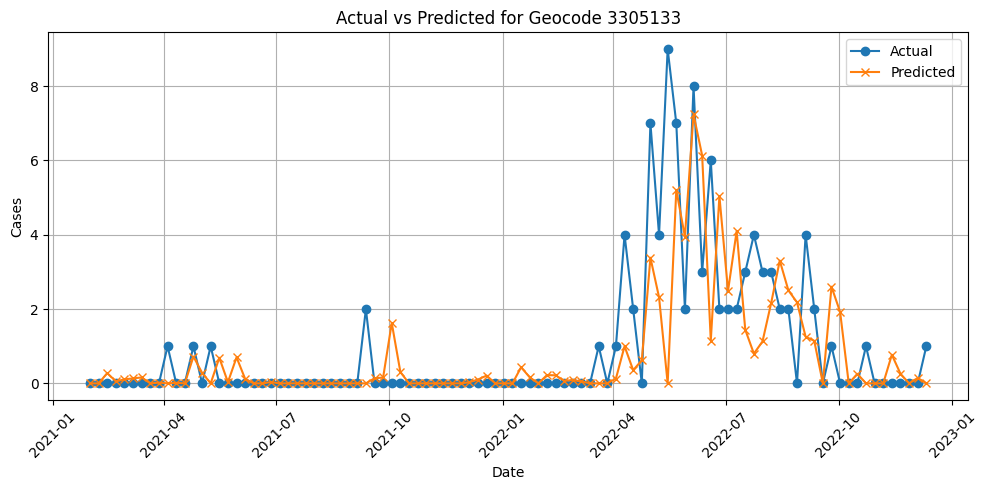

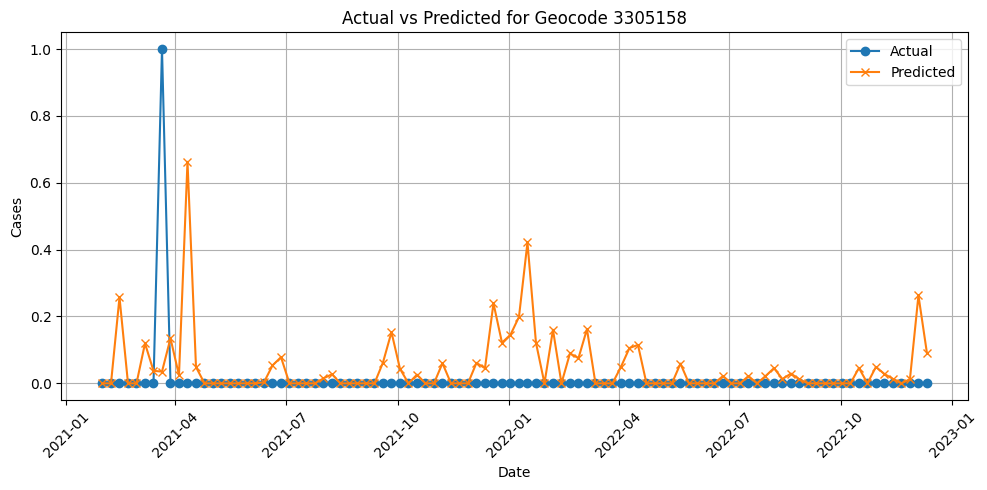

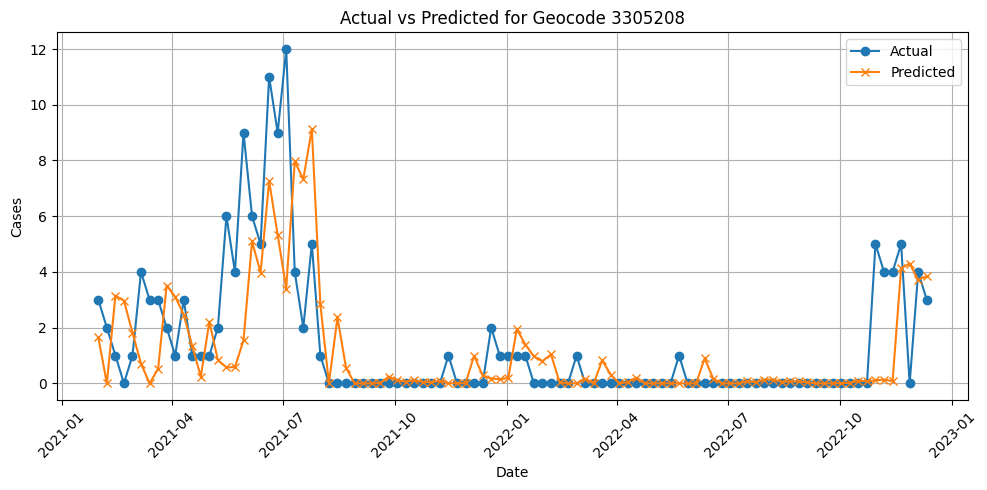

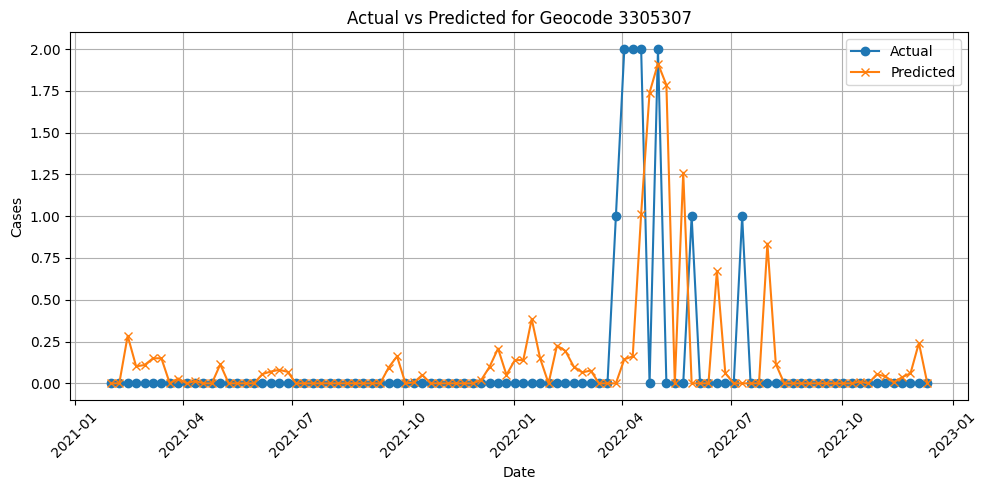

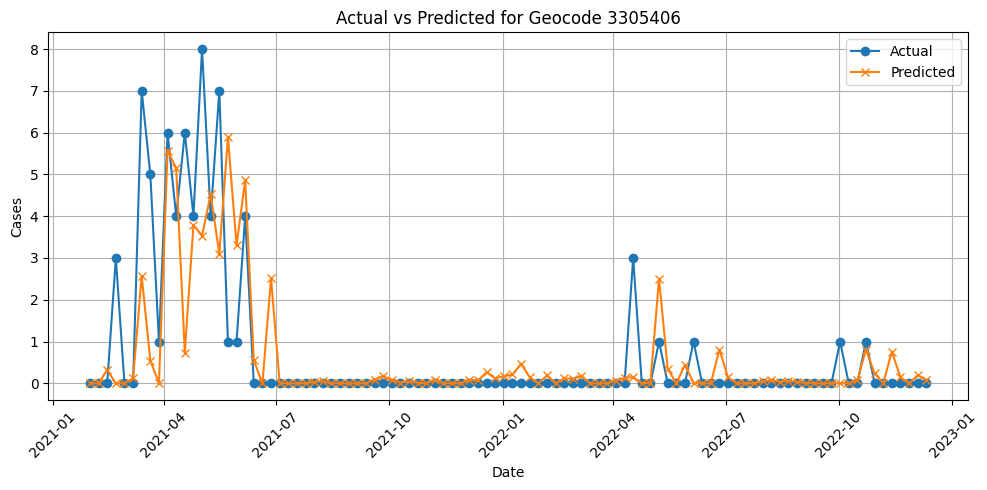

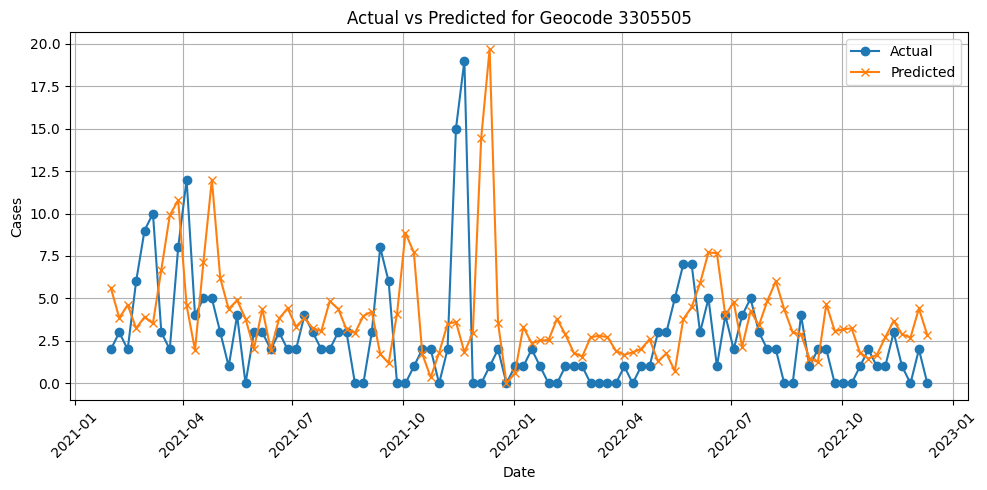

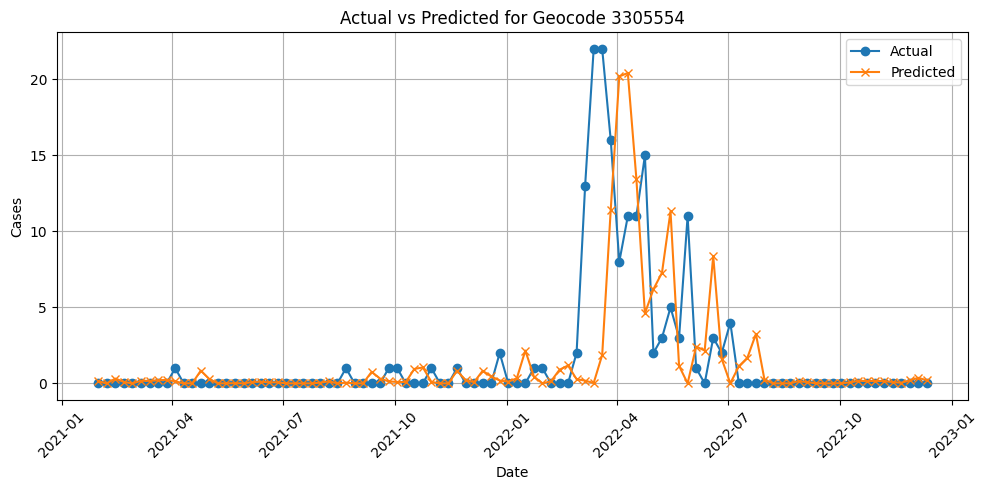

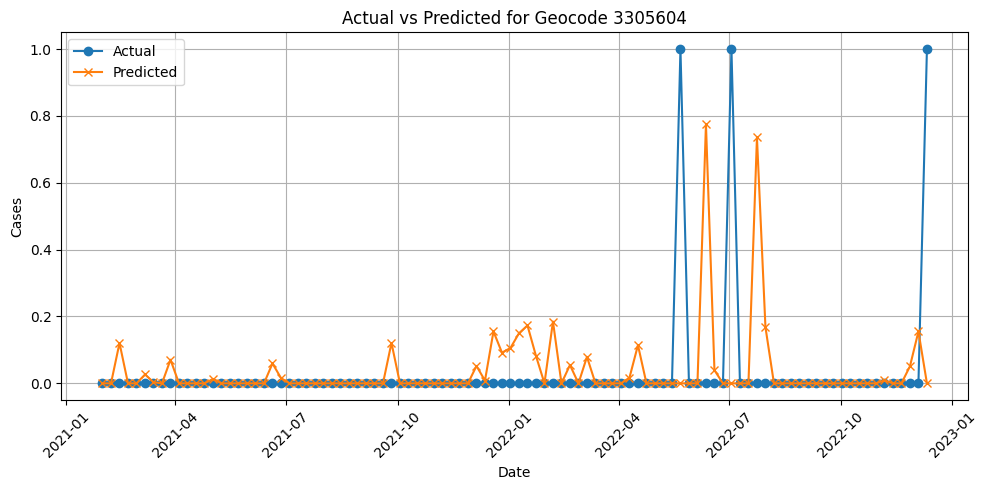

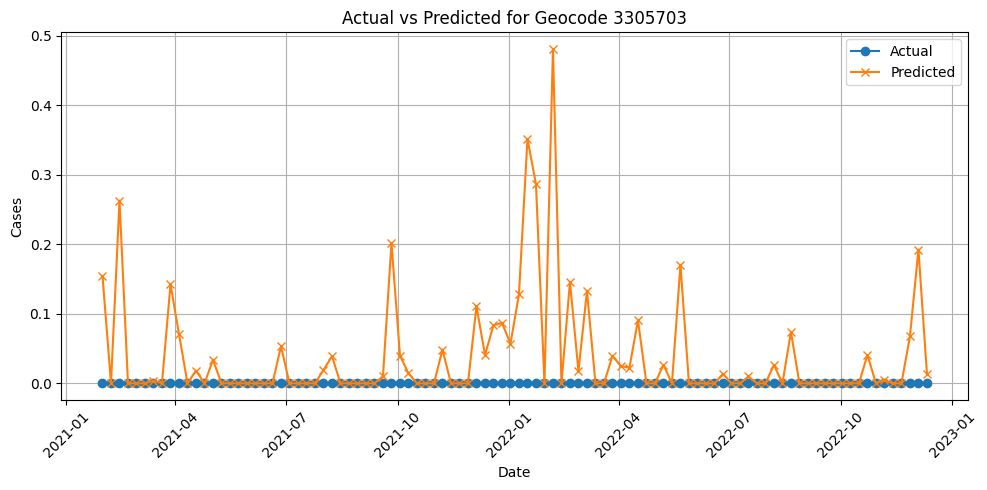

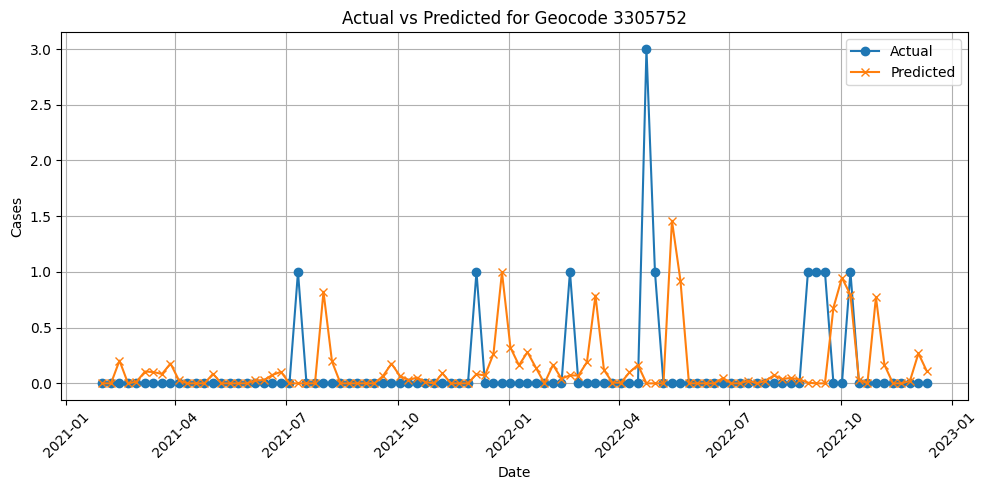

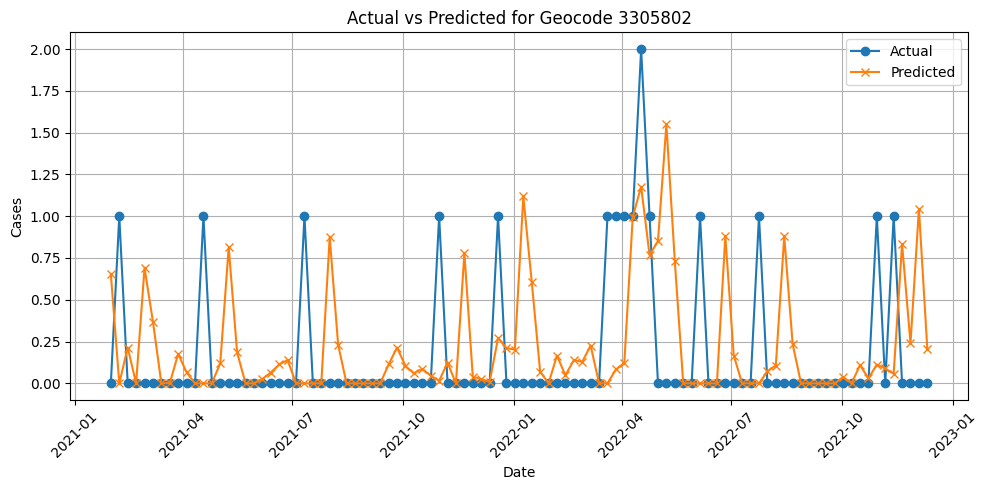

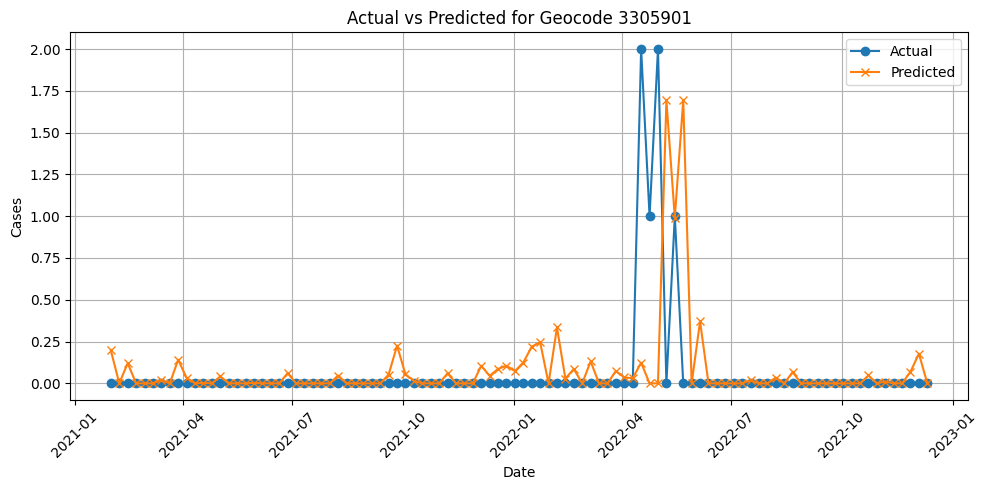

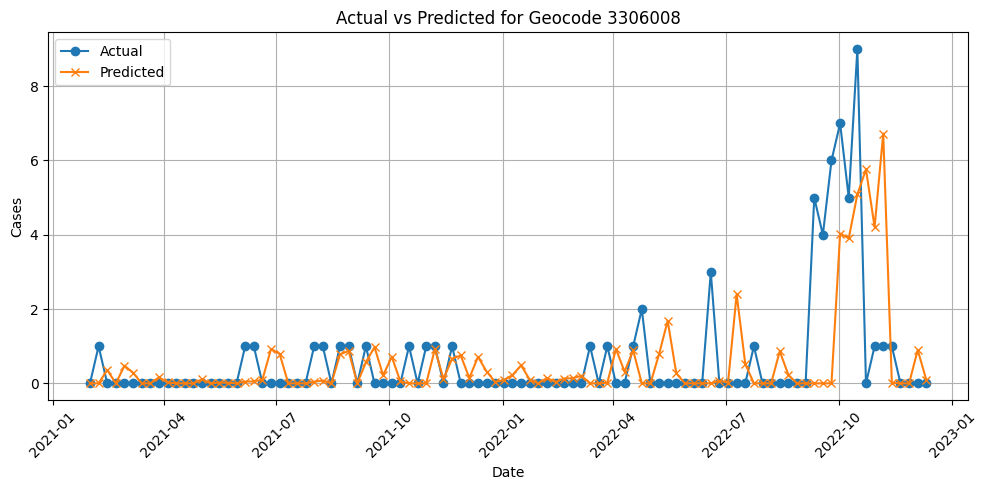

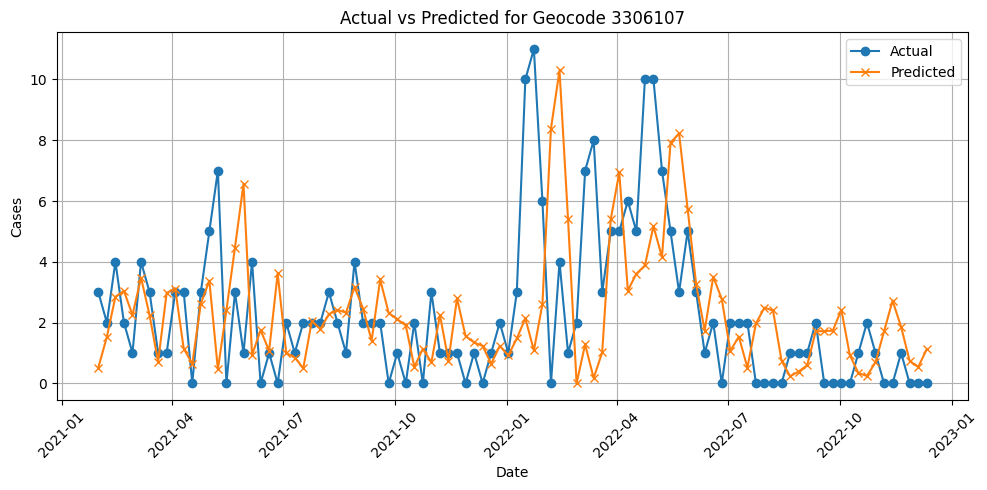

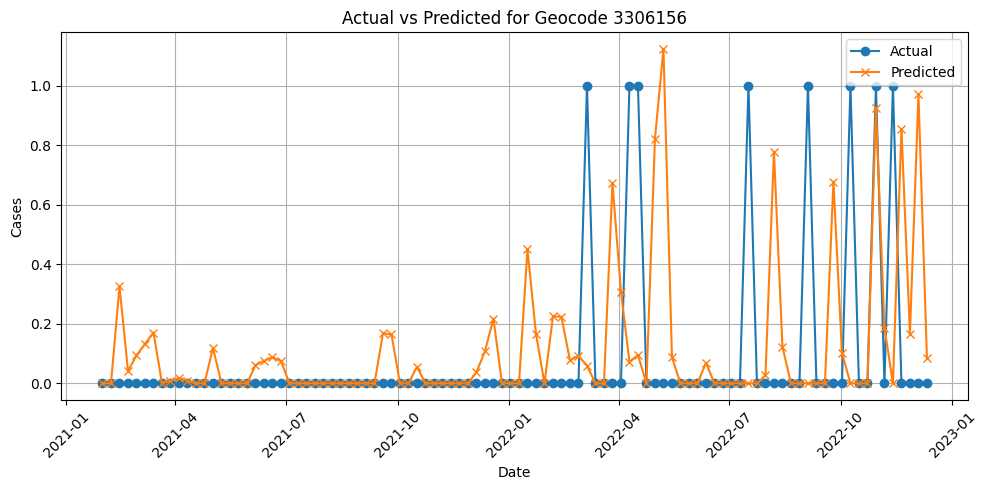

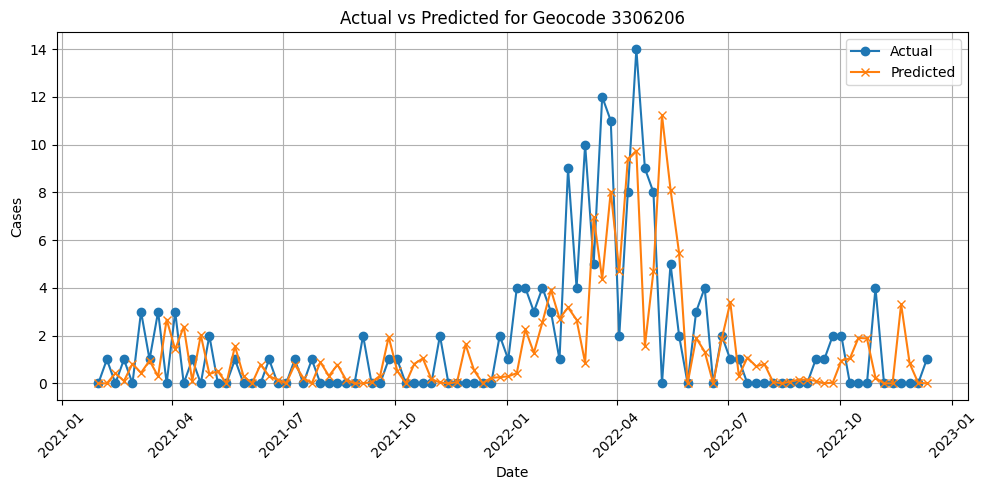

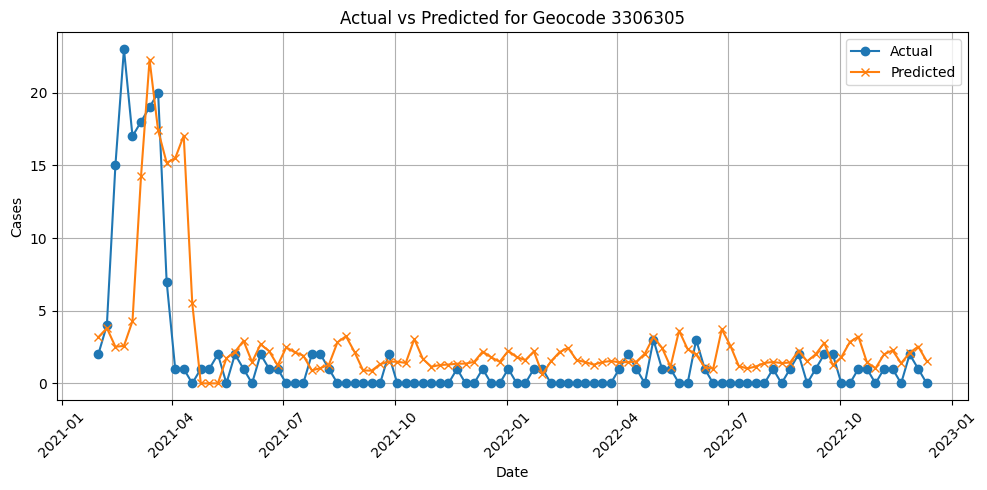

In [6]:
import matplotlib.pyplot as plt

# Optional: Limit to a few geocodes if you have many
geocodes_to_plot = test_df_seq['geocode'].unique()  # Change or remove this line to plot all

for geocode in geocodes_to_plot:
    geo_data = test_df_seq[test_df_seq['geocode'] == geocode]
    
    plt.figure(figsize=(10, 5))
    plt.plot(geo_data['date'], geo_data['actual'], label='Actual', marker='o')
    plt.plot(geo_data['date'], geo_data['lstm_pred'], label='Predicted', marker='x')
    
    plt.title(f'Actual vs Predicted for Geocode {geocode}')
    plt.xlabel('Date')
    plt.ylabel('Cases')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
